In [1]:
!pip install pandas
!pip install matplotlib
!pip install scipy


Para los comentarios

# Análisis de Datos

## Módulos y librerías utilizados

- **os**. El primer módulo nos permite utilizar funcionalidades del sistema operativo en el que se ejecuta el notebook. Lo usaremos para navegar por los directorios en los que se encuentran los datos, listarlos y cargarlos en el script.

- **json**. Este módulo permite trabajar con archivos JSON. Se combina con la librería Pandas para trabajar con datos en este formato.

- **pandas**. Se importa la librería Pandas para la manipulación de datos como DataFrames. Como se ha comentado, se combinará con el módulo json.

- **re**. El módulo re debe su nombre a que se usa para trabajar con expresiones regulares, referentes a patrones para buscar, extraer o manipular texto. Se utilizará para la gestión de directorios.

- **matplotlib.pyplot**. Es la biblioteca utilizada para la representación gráfica de los datos.

- **find_peaks de scipy.signal**. El módulo scipy.signal, de la librería de ciencia SciPy, contiene funciones para el procesado de señales. Concretamente, find_peaks se usará para la detección de máximos y mínimos locales.

In [2]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## Estructura de los bloques de análisis

### Gestión de directorios

Tras la depuración de los datos brutos, estos se reorganizaron en un árbol de directorios y se normalizaron sus nombres para automatizar su acceso.

La estructura de este árbol se explica a continuación. En el directorio `datosTFG` encontramos una carpeta para cada usuario. En cada una de ellas, encontramos carpetas para cada tipo de archivo JSON con los datos capturados:

- **Entrenamiento**: Contiene las actividades "Barra" de cada entrenamiento.
- **ResumenSaludDiario**: Contiene una carpeta por cada día de la semana de entrenamientos, llamadas `dia1`, `dia2`, ..., `dia6`. Cada carpeta contiene los archivos JSON de Resumen de Salud de ese día.
- **Estres**: Contiene los archivos de estrés y batería corporal de cada día.
- **Sleep**: Contiene los archivos de sueño de cada día.
- **Daily**: Guarda archivos con un resumen general diario. De este tipo de archivos se obtiene el consumo calórico.

Estos archivos se han nombrado siguiendo una indexación por la fecha de obtención. Se ha usado este formato (y no la propia fecha) ya que los archivos de un mismo día que contaban con datos de varias pruebas se han separado en un archivo por prueba.
'NombreArchivo_XX.json', con XX = 01, 02, ..., (0)N

Las funciones empleadas para identificar estos índices y ordenar los directorios siguen la siguiente estructura:

- En primer lugar, se especifica la ruta en la que se encuentran los archivos y se almacena en la variable `'carpeta_json'`.
- La función `obtener_numero` usa un patrón de búsqueda con la función `search` del módulo `re`. El patrón es `r'(\d+)\.json$'`, donde `\d+` busca uno o más dígitos consecutivos y `\.json$` especifica que esos dígitos están antes de la extensión '.json'. Por último, con `group(1)` se especifica que se extrae lo que está dentro de los paréntesis, en este caso, los dígitos.
- La función `sorted` ordena esta lista usando `listdir` del módulo `os`, con el criterio impuesto por `obtener_numero`, especificado en el parámetro `key`.

Finalmente, para cargar los archivos, utilizamos la siguiente expresión dentro del bucle principal, que imprime a modo de depuración si salta una excepción. Utilizamos la función `load` del paquete `json`.


## Estructura de las funciones de análisis, ejemplo: análisis de FC

Usaremos el siguiente bloque para explicar todos los siguientes:


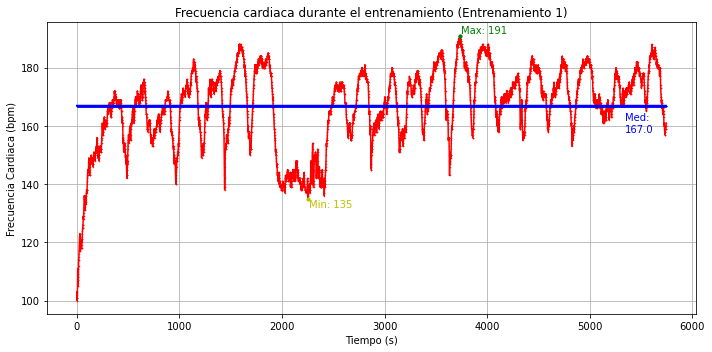

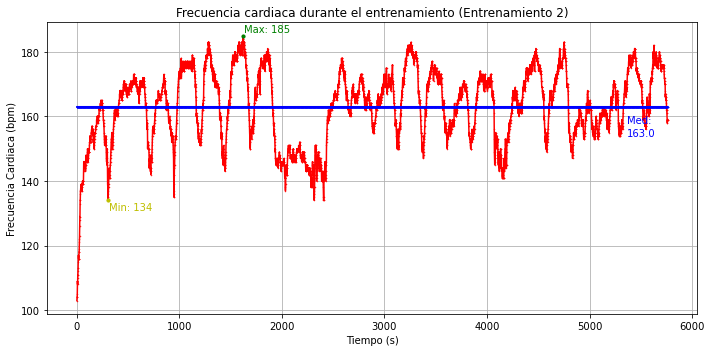

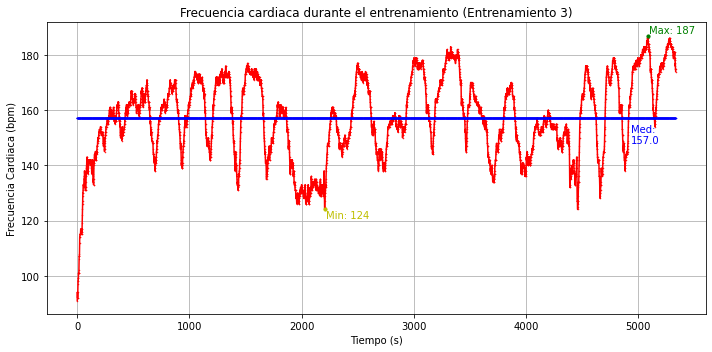

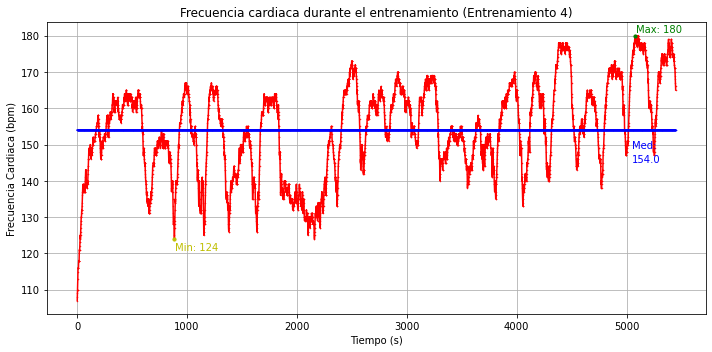

         Día  hr_medio max_hr min_hr
0      Lunes     167.0    191    135
1     Martes     163.0    185    134
2  Miércoles       NaN   None   None
3     Jueves     157.0    187    124
4    Viernes     154.0    180    124
5     Sábado       NaN   None   None


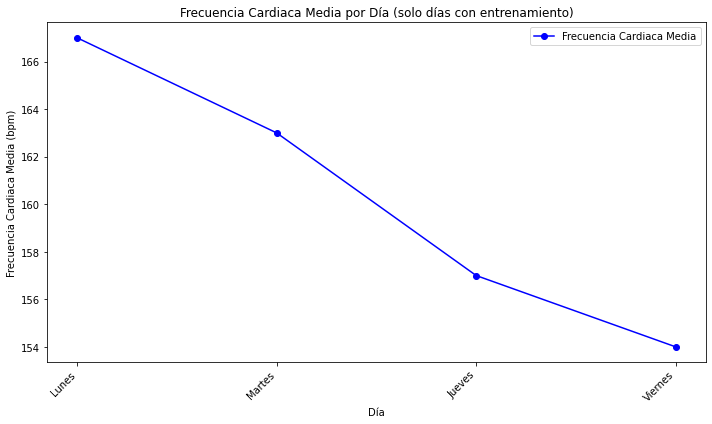

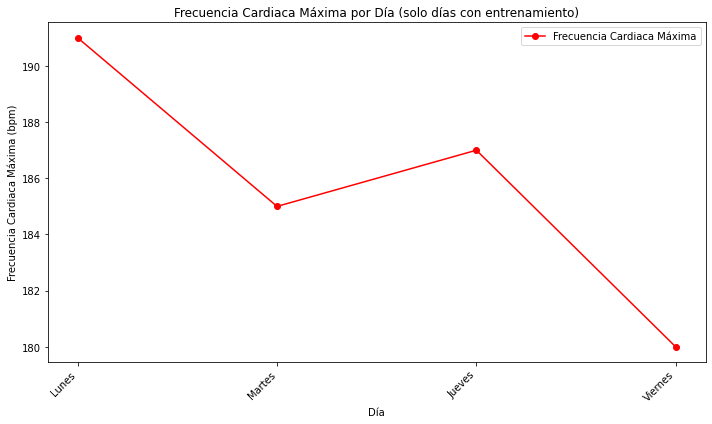

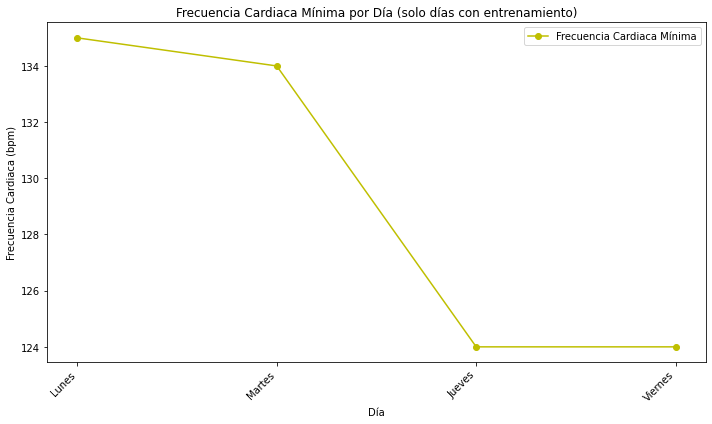

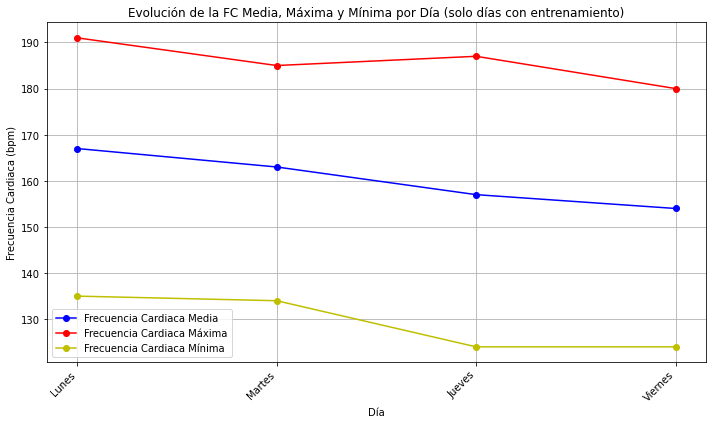

In [3]:
#ENTRENAMIENTO FC

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

## Gestión de Archivos ##
# Ruta a la carpeta en la que se encuentran los archivos de entrenamiento
carpeta_json = 'C:/Users/marco/Downloads/datosTFG/usuario1/Entrenamiento'

#Función para extraer el número del nombre del archivo
def obtener_numero(archivo):
    return int(re.search(r'(\d+)\.json$', archivo).group(1))

#Ordena los archivos según el número obtenido con la función anterior
archivos_json = sorted([archivo for archivo in os.listdir(carpeta_json) if archivo.endswith('.json')],
                       key=obtener_numero)

#Listas y variables iniciales
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
dias_entrenamiento = ['Lunes', 'Martes', 'Jueves', 'Viernes'] #Para los labels de las gráficas
hr_values = []
contador_entrenamiento = 0


for archivo in archivos_json:

    ruta_archivo = os.path.join(carpeta_json, archivo)
    
    try:
        df = pd.read_json(ruta_archivo)
    except ValueError as e:
        print(f"Error al leer {archivo}: {e}")
        continue

    #Extracción (y verificación) de datos
    df['heartRate'] = df['samples'].apply(lambda x: [item['heartRate'] for item in x])
    pd.set_option('display.max_colwidth', None)
    
    df['averageHeartRateInBeatsPerMinute'] = df['summary'].apply(lambda x: x['averageHeartRateInBeatsPerMinute'])

    if df['heartRate'].isnull().all() or df['averageHeartRateInBeatsPerMinute'].isnull().all():
        print(f"Datos de frecuencia cardíaca faltantes en el archivo {archivo}.")
        continue

    #Preparamos valores para la gráfica y los almacenamos en un array
    heart_rate_flat = df['heartRate'].iloc[0]
    hr_medio = df['averageHeartRateInBeatsPerMinute'].mean()
    mean_hr = [hr_medio] * len(heart_rate_flat) #Se crea una lista a lo largo del tiempo para imprimirla en la gráfica
    max_hr = max(heart_rate_flat)
    max_index = heart_rate_flat.index(max_hr)
    min_hr = min(heart_rate_flat[300:])  #Ignorar los primeros valores para encontrar el mínimo
    min_index = heart_rate_flat.index(min_hr, 300)

    hr_values.append({
        'Día': dias_entrenamiento[contador_entrenamiento], 
        'hr_medio': hr_medio,
        'max_hr': max_hr,
        'min_hr': min_hr
    })

    #Gráfica de FC a lo largo del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(heart_rate_flat, marker='.', markersize=1, color='r')

    #FC media
    plt.plot(mean_hr, marker='.', markersize=1, color='b')
    plt.annotate(f'Med:', xy=(len(heart_rate_flat) - 1, hr_medio),
                 xytext=(len(heart_rate_flat) - 400, hr_medio - 5), color='b')
    plt.annotate(f'{hr_medio}', xy=(len(heart_rate_flat) - 1, hr_medio),
                 xytext=(len(heart_rate_flat) - 400, hr_medio - 9), color='b')

    #FC max y min
    plt.scatter(max_index, max_hr, color='g', s=10, zorder=3, label='Max Value')  # Destacar el punto máximo
    plt.annotate(f'Max: {max_hr}', color='g', xy=(max_index, max_hr), xytext=(max_index + 10, max_hr + 1))

    plt.scatter(min_index, min_hr, color='y', s=10, zorder=3, label='Min Value')  # Destacar el punto mínimo
    plt.annotate(f'Min: {min_hr}', color='y', xy=(min_index, min_hr), xytext=(min_index + 10, min_hr - 3))

    plt.title(f'Frecuencia cardiaca durante el entrenamiento (Entrenamiento {contador_entrenamiento+1})')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia Cardiaca (bpm)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    contador_entrenamiento += 1

#Creamos DF con valores de FC
hr_df_temp = pd.DataFrame(hr_values)

#Añadimos filas con los días nulos
dias_nulos = {'Día': ['Miércoles', 'Sábado'], 'hr_medio': [None, None], 'max_hr': [None, None], 'min_hr': [None, None]}
dias_nulos_df = pd.DataFrame(dias_nulos)

#Concatenamos
hr_df = pd.concat([hr_df_temp, dias_nulos_df], ignore_index=True)
hr_df['Día'] = pd.Categorical(hr_df['Día'], categories=nombres_dias, ordered=True)
hr_df = hr_df.sort_values('Día').reset_index(drop=True)

print(hr_df)

#Filtramos para quedarnos con días de entrenamiento para las gráficas
df_solo_entrenamiento = hr_df.dropna(subset=['hr_medio', 'max_hr', 'min_hr'])

# Gráficas comparativas
#Gráfica de evolución de FC media
plt.figure(figsize=(10, 6))
plt.plot(df_solo_entrenamiento['Día'], df_solo_entrenamiento['hr_medio'], marker='o', color='b', label='Frecuencia Cardiaca Media')
plt.xticks(rotation=45, ha='right')
plt.title('Frecuencia Cardiaca Media por Día (solo días con entrenamiento)')
plt.xlabel('Día')
plt.ylabel('Frecuencia Cardiaca Media (bpm)')
plt.tight_layout()
plt.legend()
plt.show()

#Gráfica de evolución de FC máx
plt.figure(figsize=(10, 6))
plt.plot(df_solo_entrenamiento['Día'], df_solo_entrenamiento['max_hr'], marker='o', color='r', label='Frecuencia Cardiaca Máxima')
plt.xticks(rotation=45, ha='right')
plt.title('Frecuencia Cardiaca Máxima por Día (solo días con entrenamiento)')
plt.xlabel('Día')
plt.ylabel('Frecuencia Cardiaca Máxima (bpm)')
plt.tight_layout()
plt.legend()
plt.show()

#Gráfica de evolución de FC mín
plt.figure(figsize=(10, 6))
plt.plot(df_solo_entrenamiento['Día'], df_solo_entrenamiento['min_hr'], marker='o', color='y', label='Frecuencia Cardiaca Mínima')
plt.xticks(rotation=45, ha='right')
plt.title('Frecuencia Cardiaca Mínima por Día (solo días con entrenamiento)')
plt.xlabel('Día')
plt.ylabel('Frecuencia Cardiaca (bpm)')
plt.tight_layout()
plt.legend()
plt.show()

#Gráfica de evolución de FC media, máx y mín
plt.figure(figsize=(10, 6))
plt.plot(df_solo_entrenamiento['Día'], df_solo_entrenamiento['hr_medio'], marker='o', color='b', label='Frecuencia Cardiaca Media')
plt.plot(df_solo_entrenamiento['Día'], df_solo_entrenamiento['max_hr'], marker='o', color='r', label='Frecuencia Cardiaca Máxima')
plt.plot(df_solo_entrenamiento['Día'], df_solo_entrenamiento['min_hr'], marker='o', color='y', label='Frecuencia Cardiaca Mínima')
plt.xticks(rotation=45, ha='right')
plt.title('Evolución de la FC Media, Máxima y Mínima por Día (solo días con entrenamiento)')
plt.xlabel('Día')
plt.ylabel('Frecuencia Cardiaca (bpm)')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()


Índices de picos detectados en EntrenamientoBoxeo_01.json: [367, 549, 655, 887, 1036, 1138, 1292, 1394, 1584, 1760, 1864, 2467, 2586, 2807, 2961, 3073, 3326, 3455, 3564, 3731, 3909, 4012, 4194, 4297, 4437, 4549, 4731, 4866, 4975, 5091, 5254, 5354, 5456, 5605]
Índices de valles detectados en EntrenamientoBoxeo_01.json: [125, 236, 488, 738, 965, 1216, 1441, 1689, 2027, 2131, 2255, 2412, 2675, 2870, 3143, 3382, 3632, 3858, 4114, 4347, 4595, 4827, 5130, 5303, 5552, 5731]


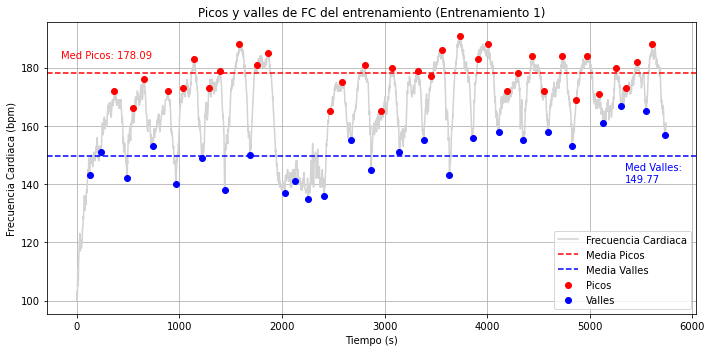

Índices de picos detectados en EntrenamientoBoxeo_02.json: [247, 431, 554, 655, 848, 1018, 1126, 1282, 1384, 1521, 1623, 1740, 1861, 2479, 2581, 2767, 2975, 3077, 3260, 3462, 3777, 3935, 4036, 4265, 4365, 4476, 4652, 4752, 4981, 5128, 5236, 5440, 5627]
Índices de valles detectados en EntrenamientoBoxeo_02.json: [111, 305, 721, 946, 1200, 1446, 1690, 1934, 2034, 2211, 2315, 2426, 2662, 2896, 3138, 3380, 3612, 3840, 4147, 4311, 4582, 4834, 4943, 5047, 5191, 5300, 5548, 5757]


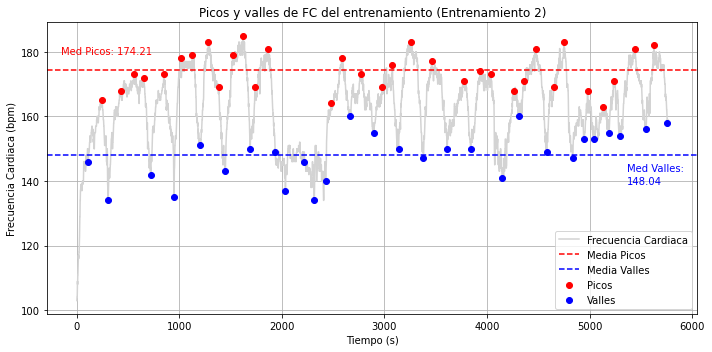

Índices de picos detectados en EntrenamientoBoxeo_03.json: [367, 484, 622, 771, 872, 1048, 1213, 1323, 1519, 1623, 1791, 2279, 2502, 2607, 2831, 3023, 3123, 3224, 3329, 3507, 3623, 3871, 4093, 4199, 4360, 4533, 4782, 4983, 5086, 5283]
Índices de valles detectados en EntrenamientoBoxeo_03.json: [145, 397, 693, 936, 1184, 1432, 1687, 1957, 2065, 2206, 2363, 2729, 2900, 3168, 3468, 3710, 3997, 4461, 4662, 4883, 5150]


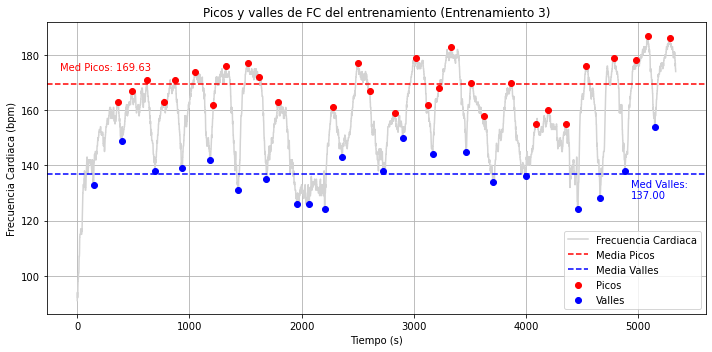

Índices de picos detectados en EntrenamientoBoxeo_04.json: [188, 326, 447, 555, 766, 983, 1221, 1330, 1554, 1701, 1812, 2313, 2498, 2665, 2766, 2918, 3021, 3130, 3239, 3381, 3498, 3647, 3758, 3868, 3980, 4168, 4447, 4643, 4894, 5100, 5291, 5407]
Índices de valles detectados en EntrenamientoBoxeo_04.json: [213, 655, 884, 1152, 1378, 1634, 1950, 2056, 2158, 2262, 2365, 2608, 2834, 3089, 3302, 3552, 3695, 3808, 4056, 4296, 4546, 4771, 4995, 5253]


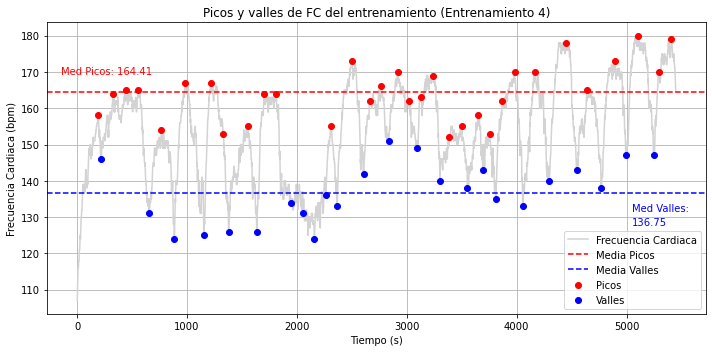

         Día  Picos Medios  Valles Medios
0      Lunes    178.088235     149.769231
1     Martes    174.212121     148.035714
2  Miércoles           NaN            NaN
3     Jueves    169.633333     137.000000
4    Viernes    164.406250     136.750000
5     Sábado           NaN            NaN


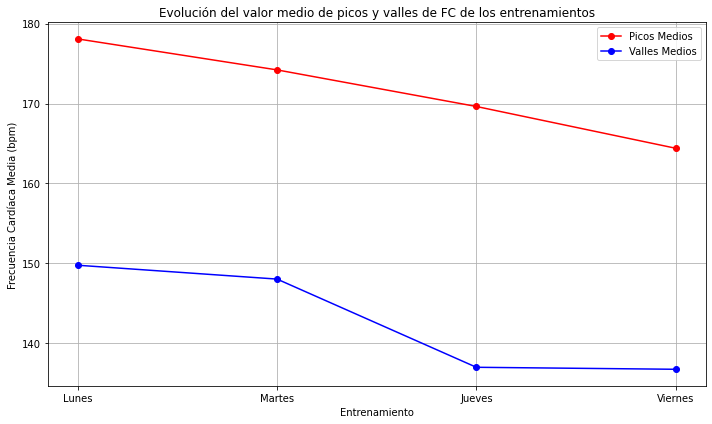

In [4]:
#PICOS HR ENTRENAMIENTOS

import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.signal import find_peaks


## Gestión de Archivos ##
# Ruta a la carpeta en la que se encuentran los archivos de entrenamiento
carpeta_json = 'C:/Users/marco/Downloads/datosTFG/usuario1/Entrenamiento'

# Función para extraer el número del nombre del archivo
def obtener_numero(archivo):
    return int(re.search(r'(\d+)\.json$', archivo).group(1))

# Ordena los archivos según el número obtenido con la función anterior
archivos_json = sorted([archivo for archivo in os.listdir(carpeta_json) if archivo.endswith('.json')],
                       key=obtener_numero)

#Diccionarios, listas y variables iniciales.
#Especificamos los picos y valles a filtrar manualmente para cada archivo, según su índice impreso más adelante
picos_a_eliminar_manual = {
    'EntrenamientoBoxeo_01.json': [3222, 5714, 2702],
    'EntrenamientoBoxeo_02.json': [2871, 3578, 5740],
    'EntrenamientoBoxeo_03.json': [],
    'EntrenamientoBoxeo_04.json': [4319]
}

valles_a_eliminar_manual = {
    'EntrenamientoBoxeo_01.json': [1, 353, 609, 844, 1909, 2984, 4215],
    'EntrenamientoBoxeo_02.json': [7, 441, 607, 2534, 3717],
    'EntrenamientoBoxeo_03.json': [3, 274, 552, 793, 1840, 2623, 3584, 3810, 4122, 4324],
    'EntrenamientoBoxeo_04.json': [29, 399, 757, 1046, 1479, 1843, 3439]
}

nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
dias_entrenamiento = ['Lunes', 'Martes', 'Jueves', 'Viernes']
picos_medios = []
valles_medios = []
contador_entrenamiento = 0


#Bucle principal
for archivo in archivos_json:
    
    ruta_archivo = os.path.join(carpeta_json, archivo)

    try:
        df = pd.read_json(ruta_archivo)
    except ValueError as e:
        print(f"Error al leer {archivo}: {e}")
        continue

    # Verificar que los campos 'samples' existen
    if 'samples' not in df.columns:
        print(f"El archivo {archivo} no contiene los campos esperados ('samples').")
        continue

    df['heartRate'] = df['samples'].apply(lambda x: [item['heartRate'] for item in x])

    heart_rate_flat = df['heartRate'].iloc[0]

    #Detección de picos y valles
    picos, _ = find_peaks(heart_rate_flat, distance=100)
    valles, _ = find_peaks([-hr for hr in heart_rate_flat], distance=100)

    #Filtrado de picos según un umbral: margen alrededor de la media
    media_hr = pd.Series(heart_rate_flat).mean()
    picos = [p for p in picos if heart_rate_flat[p] > media_hr - 3]
    valles = [v for v in valles if heart_rate_flat[v] < media_hr + 3]

    #Filtrado de picos manual
    if archivo in picos_a_eliminar_manual:
        picos = [p for p in picos if p not in picos_a_eliminar_manual[archivo]]
    if archivo in valles_a_eliminar_manual:
        valles = [v for v in valles if v not in valles_a_eliminar_manual[archivo]]

    #Calculamos los valores medios y los almacenamos
    if picos:
        picos_media = pd.Series([heart_rate_flat[p] for p in picos]).mean()
        picos_medios.append(picos_media)
    if valles:
        valles_media = pd.Series([heart_rate_flat[v] for v in valles]).mean()
        valles_medios.append(valles_media)

    #Imprimimos la lista de picos para el filtrado manual
    print(f"Índices de picos detectados en {archivo}: {picos}")
    print(f"Índices de valles detectados en {archivo}: {valles}")

    #Gráfica de picos y valles para cada entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(heart_rate_flat, color='lightgray', label='Frecuencia Cardiaca')

    plt.scatter(picos, [heart_rate_flat[p] for p in picos], color='r', label='Picos', zorder=3)
    plt.scatter(valles, [heart_rate_flat[v] for v in valles], color='b', label='Valles', zorder=3)

    plt.axhline(y=pd.Series([heart_rate_flat[p] for p in picos]).mean(), color='r', linestyle='--', label='Media Picos')
    plt.axhline(y=pd.Series([heart_rate_flat[v] for v in valles]).mean(), color='b', linestyle='--', label='Media Valles')

    plt.annotate(f'Med Picos: {picos_media:.2f}', xy=(len(heart_rate_flat) - 1, picos_media),
                 xytext=(-150, picos_media + 5), color='r')
    plt.annotate(f'Med Valles:', xy=(len(heart_rate_flat) - 1, valles_media),
                 xytext=(len(heart_rate_flat) - 400, valles_media - 5), color='b')
    plt.annotate(f'{valles_media:.2f}', xy=(len(heart_rate_flat) - 1, valles_media),
                 xytext=(len(heart_rate_flat) - 400, valles_media - 9), color='b')

    plt.title(f'Picos y valles de FC del entrenamiento (Entrenamiento {contador_entrenamiento+1})')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia Cardiaca (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    contador_entrenamiento += 1

#DF picos y valles
df_picos_valles_temp = pd.DataFrame({
    'Día': dias_entrenamiento,
    'Picos Medios': picos_medios,
    'Valles Medios': valles_medios
})

#Añadimos días sin entrenamiento
dias_nulos = {'Día': ['Miércoles', 'Sábado'], 'Picos Medios': [None, None], 'Valles Medios': [None, None]}
dias_nulos_df = pd.DataFrame(dias_nulos)

#Concatenamos
df_picos_valles = pd.concat([df_picos_valles_temp, dias_nulos_df], ignore_index=True)
df_picos_valles['Día'] = pd.Categorical(df_picos_valles['Día'], categories=nombres_dias, ordered=True)
df_picos_valles = df_picos_valles.sort_values('Día').reset_index(drop=True)

print(df_picos_valles)

#Nos quedamos con los días con entrenamiento
df_picos_valles_filtrado = df_picos_valles.dropna(subset=['Picos Medios', 'Valles Medios'])
etiquetas_entrenamientos = df_picos_valles_filtrado['Día']

#Gráfica de evolución de media de picos y valles
plt.figure(figsize=(10, 6))

plt.plot(etiquetas_entrenamientos, df_picos_valles_filtrado['Picos Medios'], marker='o', color='r', label='Picos Medios')
plt.plot(etiquetas_entrenamientos, df_picos_valles_filtrado['Valles Medios'], marker='o', color='b', label='Valles Medios')

plt.title('Evolución del valor medio de picos y valles de FC de los entrenamientos')
plt.xlabel('Entrenamiento')
plt.ylabel('Frecuencia Cardíaca Media (bpm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


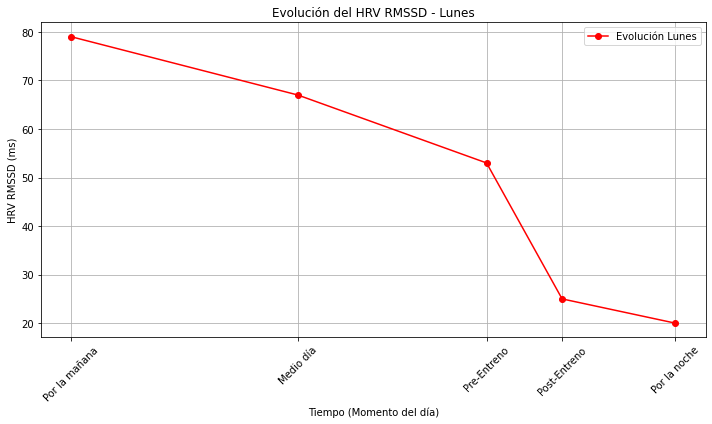

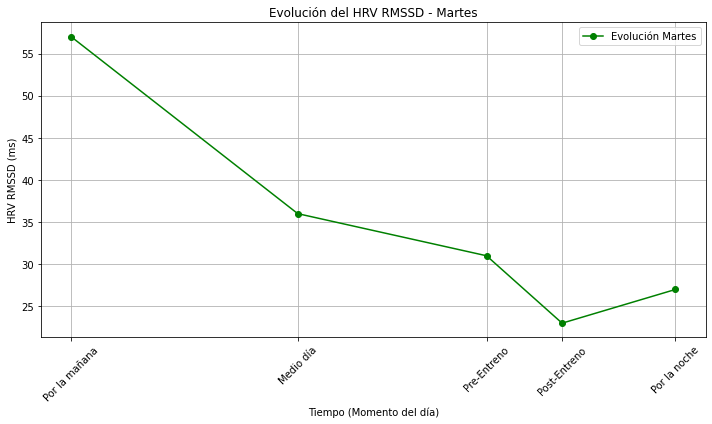

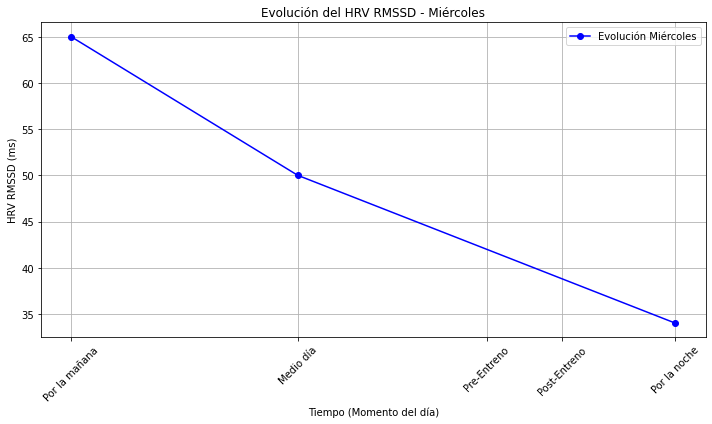

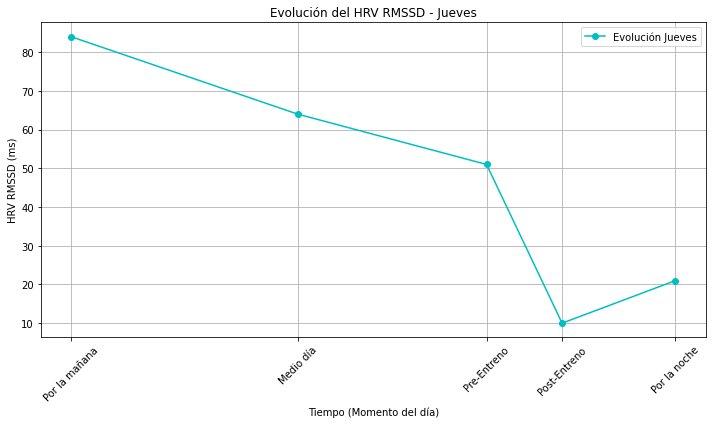

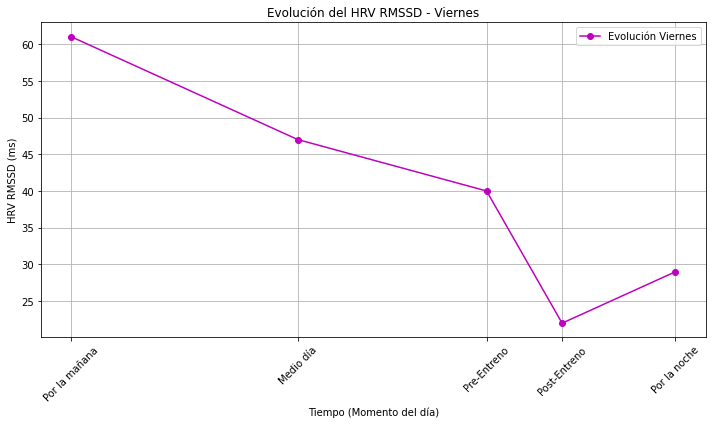

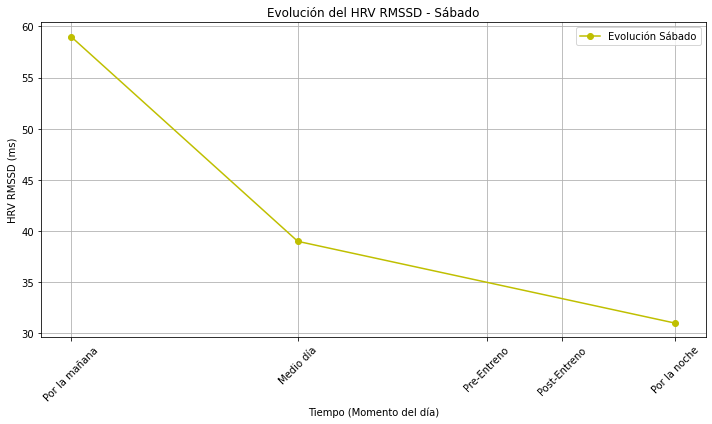

         Día  Por la mañana  Medio día  Pre-Entreno  Post-Entreno  \
0      Lunes           79.0       67.0         53.0          25.0   
1     Martes           57.0       36.0         31.0          23.0   
2  Miércoles           65.0       50.0         34.0           NaN   
3     Jueves           84.0       64.0         51.0          10.0   
4    Viernes           61.0       47.0         40.0          22.0   
5     Sábado           59.0       39.0         31.0           NaN   

   Por la noche  
0          20.0  
1          27.0  
2           NaN  
3          21.0  
4          29.0  
5           NaN  


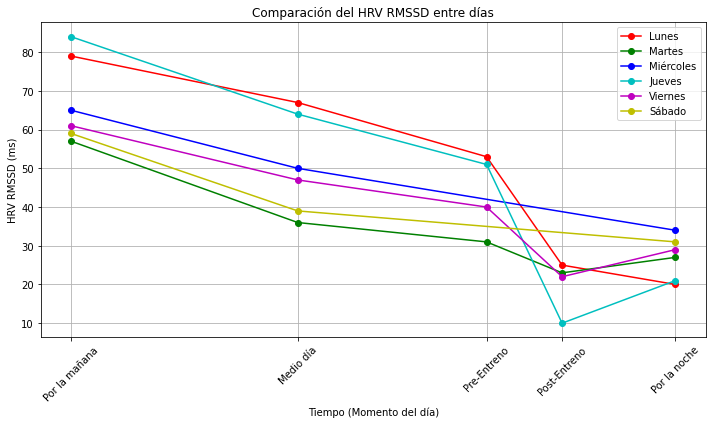

In [5]:
#HRV_RMSSD

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

# Carpeta principal que contiene las carpetas 'dia1', 'dia2', ..., 'dia6'
carpeta_principal = 'C:/Users/marco/Downloads/datosTFG/usuario1/ResumenSaludDiario'

# Función para extraer el número del nombre del archivo
def obtener_numero(archivo):
    return int(re.search(r'(\d+)\.json$', archivo).group(1))

#Listas y variables iniciales
dias = ['dia1', 'dia2', 'dia3', 'dia4', 'dia5', 'dia6']
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado'] 
colores = ['r', 'g', 'b', 'c', 'm', 'y'] 
horas_x = [8, 14, 19, 21, 24]  #Para la escala del eje X de la gráfica de evo diaria
todas_horas_x = [] 
etiquetas_x = ['Por la mañana', 'Medio día', 'Pre-Entreno', 'Post-Entreno', 'Por la noche']
todos_rmssd_values = []

for idx, dia in enumerate(dias):
    
    carpeta_dia = os.path.join(carpeta_principal, dia)

    #Ordenamos los archivos dentro del bucle principal
    archivos_json = sorted([archivo for archivo in os.listdir(carpeta_dia) if archivo.endswith('.json')],
                           key=obtener_numero)

    # Lista para almacenar los valores de RMSSD para cada archivo
    rmssd_values = []
    horas_actuales = []

    #Diferenciamos entre días con y sin entrenamiento.
    if dia in ['dia3', 'dia6']: #Sin
        horas_dia = [8, 14, 24]  #Solo 8 AM, 2 PM y 12 AM
        archivos_json = archivos_json[:3]
    else:
        horas_dia = horas_x  #Con
        archivos_json = archivos_json[:5]

    #Bucle de carga de archivos
    for archivo, hora in zip(archivos_json, horas_dia):  #Asignamos las horas correspondientes a cada archivo
        ruta_archivo = os.path.join(carpeta_dia, archivo)

        with open(ruta_archivo, 'r') as f:
            data = json.load(f)

        summaries_list = data[0]['summaries']  #Accede al primer objeto del diccionario y almacena la lista
        summaries_df = pd.DataFrame(summaries_list)

        rmssd_value = summaries_df.loc[summaries_df['summaryType'] == 'rmssd_hrv', 'avgValue'].values[0]
        rmssd_values.append(rmssd_value)
        horas_actuales.append(hora)
           
    todos_rmssd_values.append(rmssd_values)
    todas_horas_x.append(horas_actuales)

    #Gráfica de evolución diaria para cada día
    plt.figure(figsize=(10, 6))
    plt.plot(horas_actuales, rmssd_values, marker='o', linestyle='-', color=colores[idx], label=f'Evolución {nombres_dias[idx]}')
    plt.xticks(horas_x, etiquetas_x, rotation=45)
    plt.title(f'Evolución del HRV RMSSD - {nombres_dias[idx]}')
    plt.xlabel('Tiempo (Momento del día)')
    plt.ylabel('HRV RMSSD (ms)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
#DF con HRV RMSSD
rmssd_df = pd.DataFrame(todos_rmssd_values, columns=etiquetas_x[:len(todos_rmssd_values[0])])
rmssd_df['Día'] = nombres_dias[:len(rmssd_df)]
rmssd_df = rmssd_df[['Día'] + etiquetas_x[:len(todos_rmssd_values[0])]]
print(rmssd_df)
        
#Gráfica comparativa final con todos los días
plt.figure(figsize=(10, 6))

for idx, (rmssd_values, horas_actuales) in enumerate(zip(todos_rmssd_values, todas_horas_x)):
    plt.plot(horas_actuales, rmssd_values, marker='o', linestyle='-', color=colores[idx], label=nombres_dias[idx])

plt.xticks(horas_x, etiquetas_x, rotation=45)
plt.title('Comparación del HRV RMSSD entre días')
plt.xlabel('Tiempo (Momento del día)')
plt.ylabel('HRV RMSSD (ms)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Datos de Respiración Pre, Durante y Post-Entrenamiento (incluye días de descanso con NaN):
         Día  Respiración Pre  Respiración Durante  Respiración Post  \
0      Lunes          13.6400                 19.0             15.00   
1     Martes          14.6100                 19.0             16.00   
2  Miércoles              NaN                  NaN               NaN   
3     Jueves          15.0000                 18.0             15.09   
4    Viernes          14.0002                 19.0             16.00   
5     Sábado              NaN                  NaN               NaN   

   Balance Respiración  
0               1.3600  
1               1.3900  
2                  NaN  
3               0.0900  
4               1.9998  
5                  NaN  
Datos de Estrés Pre y Post-Entrenamiento (incluye días de descanso con NaN):
         Día  Estrés Pre  Estrés Post
0      Lunes        67.0         99.0
1     Martes        91.0        100.0
2  Miércoles         NaN          NaN


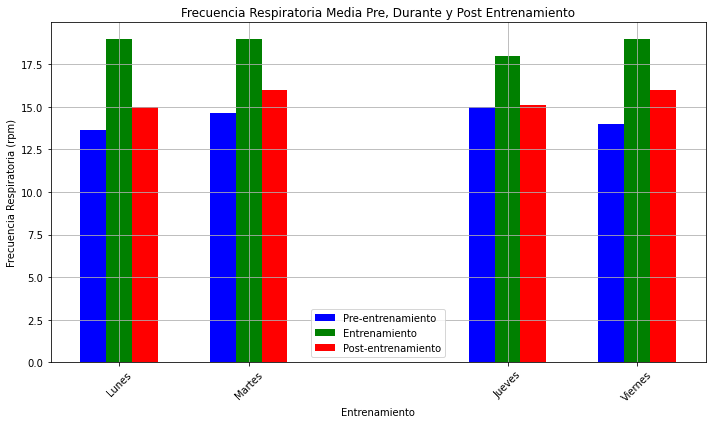

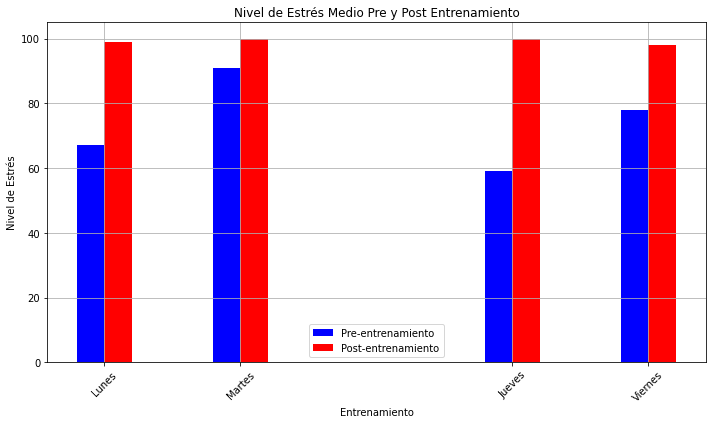

In [6]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

# Carpeta principal que contiene las carpetas 'dia1', 'dia2', ..., 'dia6'
carpeta_principal = 'C:/Users/marco/Downloads/datosTFG/usuario1/ResumenSaludDiario'

#Función para extraer el índice del archivo
def obtener_numero(archivo):
    return int(re.search(r'(\d+)\.json$', archivo).group(1))

#Diccionarios, listas y variables iniciales
#Archivos a analizar. Se indican los días de entrenamiento y los archivos correspondientes a los RdS pre y post entrenamiento.
entrenamientos = {
    'dia1': (3, 4),
    'dia2': (8, 9),
    'dia4': (16, 17),
    'dia5': (21, 22)
}

#Volcado manual de la respiración media durante el entrenamiento
respiracion_durante_entrenamiento = {
    'dia1': 19,
    'dia2': 19,
    'dia4': 18,
    'dia5': 19
}

dias = ['dia1', 'dia2', 'dia3', 'dia4', 'dia5', 'dia6']
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado'] 
datos_respiracion = []
datos_estres = []


#Bucle principal
for idx, dia in enumerate(dias):
    nombre_dia = nombres_dias[idx]  

    #Gestión de directorios 
    carpeta_dia = os.path.join(carpeta_principal, dia)
    
    #Función de ordenación por índice del archivo dentro del bucle principal
    archivos_json = sorted([archivo for archivo in os.listdir(carpeta_dia) if archivo.endswith('.json')],
                           key=obtener_numero)

    if dia in entrenamientos: #Los días de entrenamiento dividimos entre pre y post entrenamiento
        pre_entrenamiento_idx, post_entrenamiento_idx = entrenamientos[dia] #Se declara para dicho día los archivos pre y post según el diccionario

        ## Carga de datos ## Se indica qué archivos de la lista buscamos, para cargar los datos diferenciando entre pre y post
        archivos_necesarios = [f'{pre_entrenamiento_idx:02d}', f'{post_entrenamiento_idx:02d}']
        archivos_presentes = [archivo for archivo in archivos_json if any(f'_{num}.json' in archivo for num in archivos_necesarios)]
        
        #Función que carga dos datos de estrés y respiración según nombre del archivo, nos permite cargar diferenciando entre pre y post
        def cargar_datos_pre_post(archivo):
            with open(os.path.join(carpeta_dia, archivo), 'r') as f:
                data = json.load(f)
            if isinstance(data, list) and 'summaries' in data[0]:
                summaries_df = pd.DataFrame(data[0]['summaries'])
                respiracion = summaries_df.loc[summaries_df['summaryType'] == 'respiration', 'avgValue'].values[0]
                estres = summaries_df.loc[summaries_df['summaryType'] == 'stress', 'avgValue'].values[0]
                return respiracion, estres
            else:
                print(f"Advertencia: No se encontraron datos de 'summaries' en {archivo}")
                return None, None

        respiracion_pre_value, estres_pre_value = cargar_datos_pre_post(archivos_presentes[0])
        respiracion_post_value, estres_post_value = cargar_datos_pre_post(archivos_presentes[1])

        #Días de entrenamiento
        if respiracion_pre_value is not None and respiracion_post_value is not None:
            datos_respiracion.append({
                'Día': nombre_dia,
                'Respiración Pre': respiracion_pre_value,
                'Respiración Durante': respiracion_durante_entrenamiento[dia],
                'Respiración Post': respiracion_post_value,
                'Balance Respiración': respiracion_post_value - respiracion_pre_value
            })
            datos_estres.append({
                'Día': nombre_dia,
                'Estrés Pre': estres_pre_value,
                'Estrés Post': estres_post_value
            })
    else:
        #Días sin entrenamiento
        datos_respiracion.append({
            'Día': nombre_dia,
            'Respiración Pre': None,
            'Respiración Durante': None,
            'Respiración Post': None,
            'Balance Respiración': None
        })
        datos_estres.append({
            'Día': nombre_dia,
            'Estrés Pre': None,
            'Estrés Post': None
        })

#DFs con datos de respiración y estrés
df_respiracion = pd.DataFrame(datos_respiracion)
df_estres = pd.DataFrame(datos_estres)

#Mostramos los DFs
print("Datos de Respiración Pre, Durante y Post-Entrenamiento (incluye días de descanso con NaN):")
print(df_respiracion)
print("Datos de Estrés Pre y Post-Entrenamiento (incluye días de descanso con NaN):")
print(df_estres)

#Nos quedamos con días de entrenamiento
df_solo_entrenamiento = df_respiracion.dropna(subset=['Respiración Pre', 'Respiración Durante', 'Respiración Post'])
df_estres_solo_entrenamiento = df_estres[df_estres['Día'].isin(df_solo_entrenamiento['Día'])]

# Gráfica de Respiración: Pre-entrenamiento, Entrenamiento y Post-entrenamiento
etiquetas_x = [nombre_dia for nombre_dia in df_solo_entrenamiento['Día']]
plt.figure(figsize=(10, 6))
plt.bar(df_solo_entrenamiento.index - 0.2, df_solo_entrenamiento['Respiración Pre'], width=0.2, label='Pre-entrenamiento', color='b')
plt.bar(df_solo_entrenamiento.index, df_solo_entrenamiento['Respiración Durante'], width=0.2, label='Entrenamiento', color='g')
plt.bar(df_solo_entrenamiento.index + 0.2, df_solo_entrenamiento['Respiración Post'], width=0.2, label='Post-entrenamiento', color='r')
plt.xticks(df_solo_entrenamiento.index, etiquetas_x, rotation=45)
plt.title('Frecuencia Respiratoria Media Pre, Durante y Post Entrenamiento')
plt.ylabel('Frecuencia Respiratoria (rpm)')
plt.xlabel('Entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfica de Estrés: Pre-entrenamiento y Post-entrenamiento
plt.figure(figsize=(10, 6))
plt.bar(df_estres_solo_entrenamiento.index - 0.1, df_estres_solo_entrenamiento['Estrés Pre'], width=0.2, label='Pre-entrenamiento', color='b')
plt.bar(df_estres_solo_entrenamiento.index + 0.1, df_estres_solo_entrenamiento['Estrés Post'], width=0.2, label='Post-entrenamiento', color='r')
plt.xticks(df_estres_solo_entrenamiento.index, etiquetas_x, rotation=45)
plt.title('Nivel de Estrés Medio Pre y Post Entrenamiento')
plt.ylabel('Nivel de Estrés')
plt.xlabel('Entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



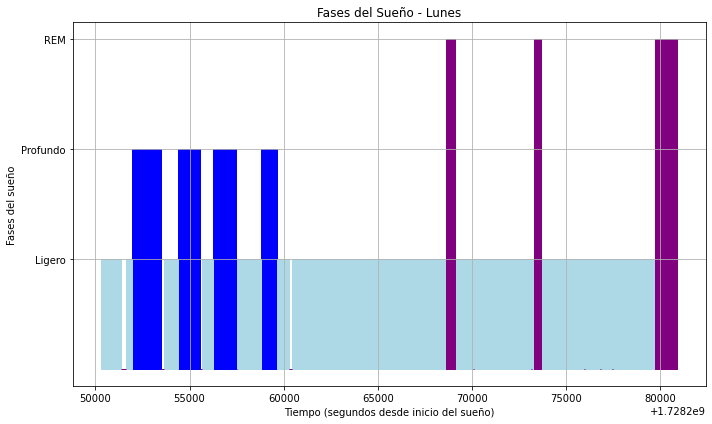

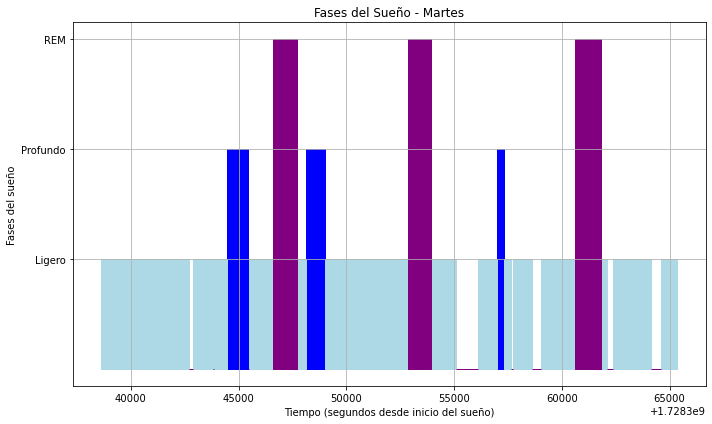

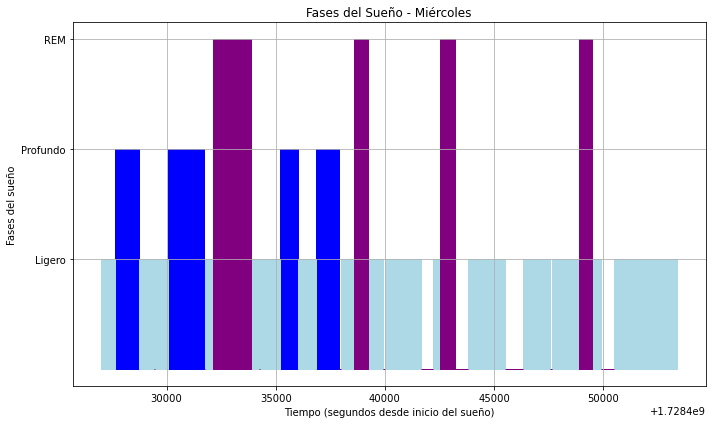

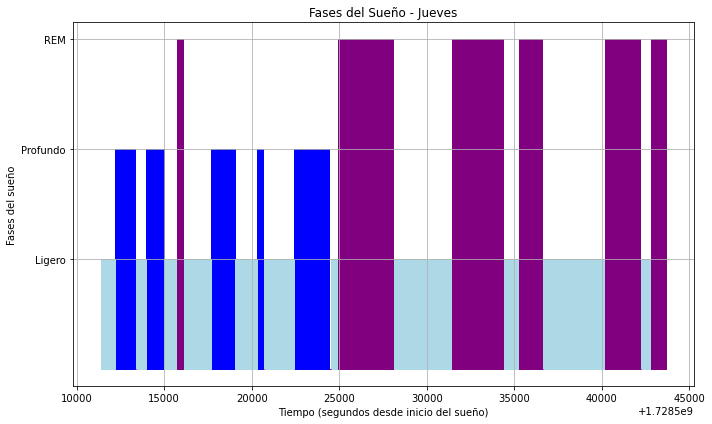

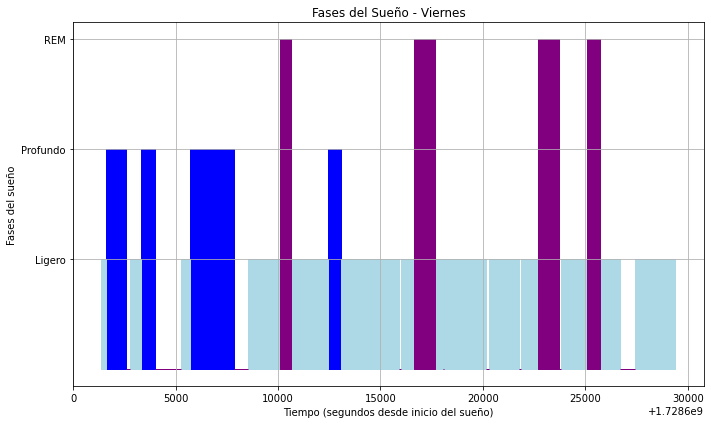

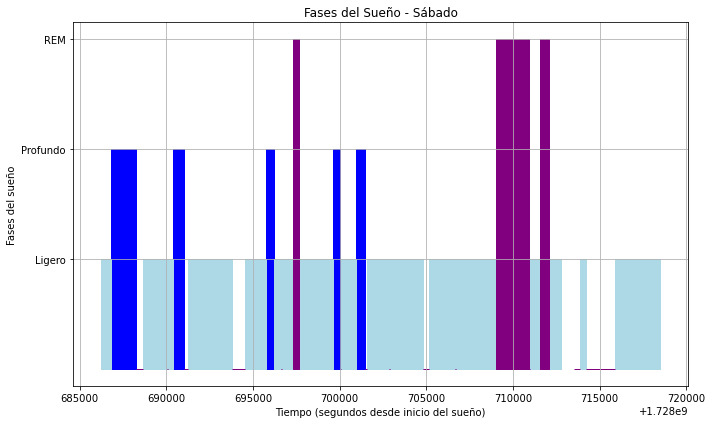

         Día  Puntuación Global Calificación Global Duración Total     Estrés  \
0      Lunes                 77                FAIR      EXCELLENT  EXCELLENT   
1     Martes                 70                FAIR           FAIR  EXCELLENT   
2  Miércoles                 65                FAIR           FAIR  EXCELLENT   
3     Jueves                 94           EXCELLENT      EXCELLENT  EXCELLENT   
4    Viernes                 71                FAIR           FAIR  EXCELLENT   
5     Sábado                 55                POOR           FAIR  EXCELLENT   

   Inquietud  Despertar   REM Sueño Ligero Sueño Profundo  
0  EXCELLENT  EXCELLENT  POOR         FAIR           GOOD  
1       FAIR       POOR  FAIR         FAIR           FAIR  
2       POOR       POOR  FAIR         FAIR      EXCELLENT  
3  EXCELLENT  EXCELLENT  FAIR    EXCELLENT      EXCELLENT  
4       POOR       POOR  FAIR         FAIR      EXCELLENT  
5       POOR       POOR  POOR         FAIR           FAIR  


,Día,Puntuación Global,Calificación Global,Duración Total,Estrés,Inquietud,Despertar,REM,Sueño Ligero,Sueño Profundo
0,Lunes,77,FAIR,EXCELLENT,EXCELLENT,EXCELLENT,EXCELLENT,POOR,FAIR,GOOD
1,Martes,70,FAIR,FAIR,EXCELLENT,FAIR,POOR,FAIR,FAIR,FAIR
2,Miércoles,65,FAIR,FAIR,EXCELLENT,POOR,POOR,FAIR,FAIR,EXCELLENT
3,Jueves,94,EXCELLENT,EXCELLENT,EXCELLENT,EXCELLENT,EXCELLENT,FAIR,EXCELLENT,EXCELLENT
4,Viernes,71,FAIR,FAIR,EXCELLENT,POOR,POOR,FAIR,FAIR,EXCELLENT
5,Sábado,55,POOR,FAIR,EXCELLENT,POOR,POOR,POOR,FAIR,FAIR


In [7]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

#Carpeta con archivo de sueño
carpeta_sueno = 'C:/Users/marco/Downloads/datosTFG/usuario1/Sleep'

# Función para extraer el número del archivo (asumiendo que termina en algo como 'archivo_01.json')
def obtener_numero(archivo):
    return int(re.search(r'(\d+)\.json$', archivo).group(1))

# Ordenar los archivos por el índice al final
archivos_json = sorted([archivo for archivo in os.listdir(carpeta_sueno) if archivo.endswith('.json')], key=obtener_numero)

#Función de gestión de niveles del sueño
def procesar_fases_sueno(sleep_levels_map):
    tiempos = []
    niveles = []
    for nivel, segmentos in sleep_levels_map.items():
        if nivel == "unmeasurable":  # Ignorar segmentos 'no medibles'
            continue
        altura = 0
        if nivel == "light":
            altura = 1  # Altura sueño ligero
        elif nivel == "deep":
            altura = 2  # Altura sueño profundo
        elif nivel == "rem":
            altura = 3  # Altura REM

        for segmento in segmentos:
            tiempos.append((segmento['startTimeInSeconds'], segmento['endTimeInSeconds']))
            niveles.append(altura)

    return tiempos, niveles

#Asignación de colores según la calificación
def color_cell(value):
    if value == 'POOR':
        return 'background-color: red'
    elif value == 'FAIR':
        return 'background-color: yellow'
    elif value == 'GOOD':
        return 'background-color: lightgreen'
    elif value == 'EXCELLENT':
        return 'background-color: green'
    return ''

#Listas para almacenar variables
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
calificaciones_dias = []


#Bucle principal
for idx, archivo in enumerate(archivos_json):
    ruta_archivo = os.path.join(carpeta_sueno, archivo)
    
    try:
        with open(ruta_archivo, 'r') as f:
            data = json.load(f)
    except ValueError as e:
        print(f"Error al leer {archivo}: {e}")
        continue

    #Obtenemos (si hay) los datos de sueño almacenados en un mapa de niveles
    if isinstance(data, list) and len(data) > 0:
        sleep_data = data[0]
        sleep_levels_map = sleep_data.get('sleepLevelsMap', {})

        #Mapeamos los niveles al tiempo de sueño con la función previa
        tiempos, niveles = procesar_fases_sueno(sleep_levels_map)

        
        plt.figure(figsize=(10, 6))
        
        for (start, end), nivel in zip(tiempos, niveles):
                #Rellenamos los segmentos correspondientes a cada zona a modo de barras
            plt.fill_between([start, end], 0, nivel, color='lightblue' if nivel == 1 else ('b' if nivel == 2 else 'purple'))

        plt.yticks([1, 2, 3], ['Ligero', 'Profundo', 'REM'])
        dia_semana = dias_semana[idx % len(dias_semana)]  
        
        
        plt.title(f'Fases del Sueño - {dia_semana}')  
        plt.xlabel('Tiempo (segundos desde inicio del sueño)')
        plt.ylabel('Fases del sueño')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        

        #Extracción de calificaciones
        overall_score = sleep_data.get('overallSleepScore', {}).get('value', None)
        overall_qualifier = sleep_data.get('overallSleepScore', {}).get('qualifierKey', None)
        sleep_scores = sleep_data.get('sleepScores', {})

        #Almacenamiento en la lista
        calificaciones_dias.append({
            'Día': dias_semana[idx % len(dias_semana)],  # Asignar el día correspondiente
            'Puntuación Global': overall_score,
            'Calificación Global': overall_qualifier,
            'Duración Total': sleep_scores.get('totalDuration', {}).get('qualifierKey', None),
            'Estrés': sleep_scores.get('stress', {}).get('qualifierKey', None),
            'Inquietud': sleep_scores.get('restlessness', {}).get('qualifierKey', None),
            'Despertar': sleep_scores.get('awakeCount', {}).get('qualifierKey', None),
            'REM': sleep_scores.get('remPercentage', {}).get('qualifierKey', None),
            'Sueño Ligero': sleep_scores.get('lightPercentage', {}).get('qualifierKey', None),
            'Sueño Profundo': sleep_scores.get('deepPercentage', {}).get('qualifierKey', None)
        })

#DF con las calificaciones de sueño
df_sueno = pd.DataFrame(calificaciones_dias)
print(df_sueno)
#Visualización con mapeo de colores
styled_df = df_sueno.style.applymap(color_cell, subset=['Calificación Global', 'Duración Total', 'Estrés', 'Despertar', 'REM', 'Inquietud', 'Sueño Ligero', 'Sueño Profundo'])
styled_df


         Día  Calorías Totales  Calorías Reposo  Calorías Activas  \
0      Lunes              3959             2405              1554   
1     Martes              4040             2405              1635   
2  Miércoles              2812             2405               407   
3     Jueves              3730             2405              1325   
4    Viernes              3732             2405              1327   
5     Sábado              2694             2405               289   

   Calorías Entrenamiento  
0                    1266  
1                    1196  
2                       0  
3                    1025  
4                    1043  
5                       0  


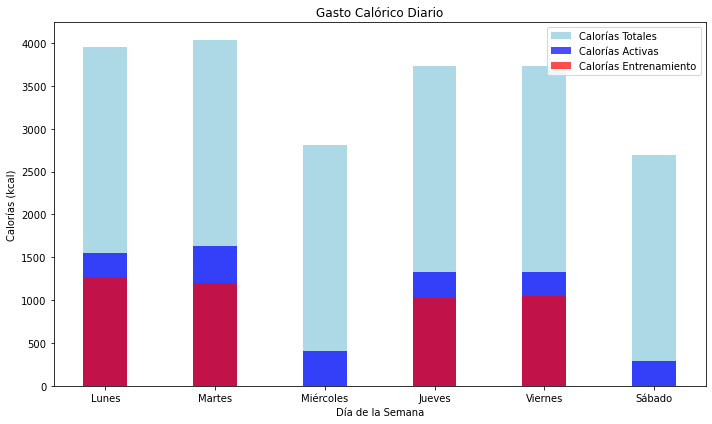

In [8]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta que contiene los archivos JSON de gasto calórico
carpeta_calorias = 'C:/Users/marco/Downloads/datosTFG/usuario1/Daily'

# Función para extraer el número del archivo (asumiendo que termina en algo como 'archivo_01.json')
def obtener_numero(archivo):
    return int(re.search(r'(\d+)\.json$', archivo).group(1))

# Ordenar los archivos por el índice al final
archivos_json = sorted([archivo for archivo in os.listdir(carpeta_calorias) if archivo.endswith('.json')], key=obtener_numero)




#Diccionarios y listas para almacenar variables
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
calorias_totales = []
calorias_reposo = []
calorias_activas = []
calorias_entrenos = []
#Volcado manual de las calorías de los entrenamientos
calorias_entrenamiento = { # 1:Lunes, 2:Martes, 4:Jueves, 5:Viernes
    1: 1266,  
    2: 1196,  
    4: 1025,  
    5: 1043   
}

#Bucle que itera sobre los archivos
for archivo in archivos_json:
    
    ruta_archivo = os.path.join(carpeta_calorias, archivo)
    
    try:
        with open(ruta_archivo, 'r') as f:
            data = json.load(f)
    except ValueError as e:
        print(f"Error al leer {archivo}: {e}")
        continue

    # Verificar que el archivo contiene las calorías
    if isinstance(data, list) and len(data) > 0:
        calorias_data = data[0]

        #Extracción de datos
        active_calories = calorias_data.get('activeKilocalories', 0)
        bmr_calories = calorias_data.get('bmrKilocalories', 0)
        calorias_totales_dia = active_calories + bmr_calories

        #Almacenado en las listas
        calorias_totales.append(calorias_totales_dia)
        calorias_activas.append(active_calories)
        calorias_reposo.append(bmr_calories)
        
         #Añadimos las calorías de entrenamiento si es un día con entrenamiento
        dia_indice = obtener_numero(archivo)
    
        if dia_indice in calorias_entrenamiento:
            calorias_entrenos.append(calorias_entrenamiento[dia_indice])
        else:
            calorias_entrenos.append(0)  # i no hay entrenamiento, calorías de entrenamiento = 0

#DF de gasto calórico
calorias_total = {
    'Día': dias_semana, 
    'Calorías Totales': calorias_totales,
    'Calorías Reposo' : calorias_reposo,
    'Calorías Activas': calorias_activas,
    'Calorías Entrenamiento': calorias_entrenos
}
df_calorias = pd.DataFrame(calorias_total)
print(df_calorias)

#Gráfica de gasto calórico
plt.figure(figsize=(10, 6))

bar_width = 0.4
indice_barras = range(len(df_calorias))

plt.bar(indice_barras, df_calorias['Calorías Totales'], bar_width, label='Calorías Totales', color='lightblue')
plt.bar(indice_barras, df_calorias['Calorías Activas'], bar_width, label='Calorías Activas', color='blue', alpha=0.7)
plt.bar(indice_barras, df_calorias['Calorías Entrenamiento'], bar_width, label='Calorías Entrenamiento', color='red', alpha=0.7)

plt.xticks(indice_barras, df_calorias['Día'])
plt.title('Gasto Calórico Diario')
plt.xlabel('Día de la Semana')
plt.ylabel('Calorías (kcal)')
plt.legend()
plt.tight_layout()
plt.show()

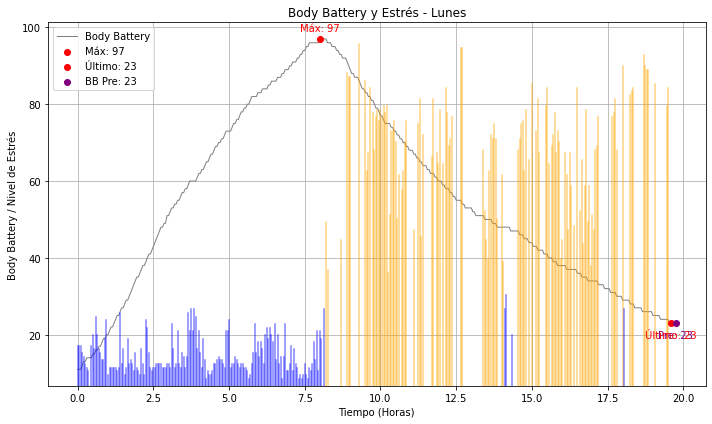

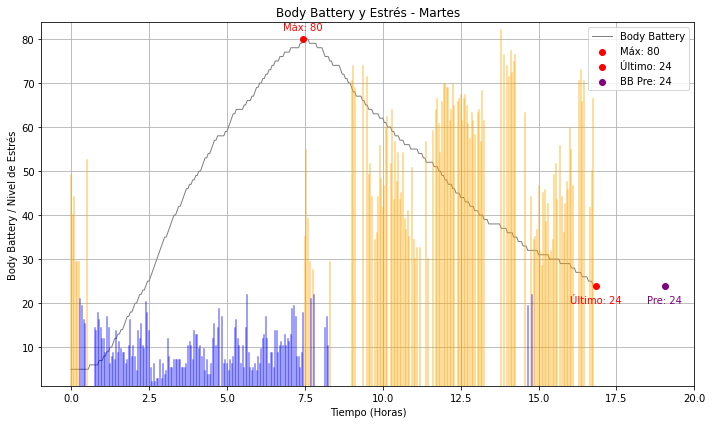

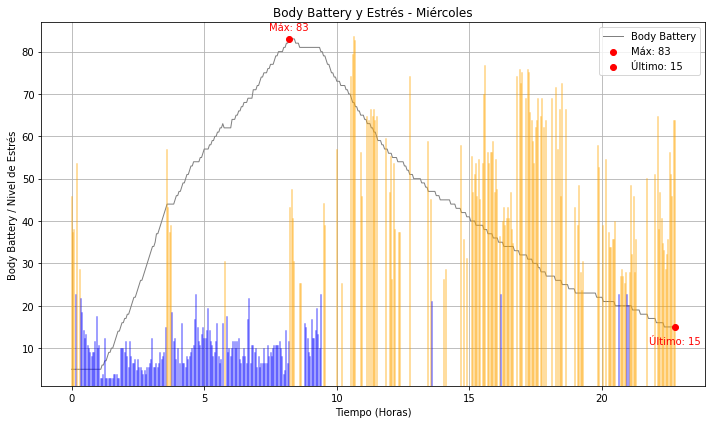

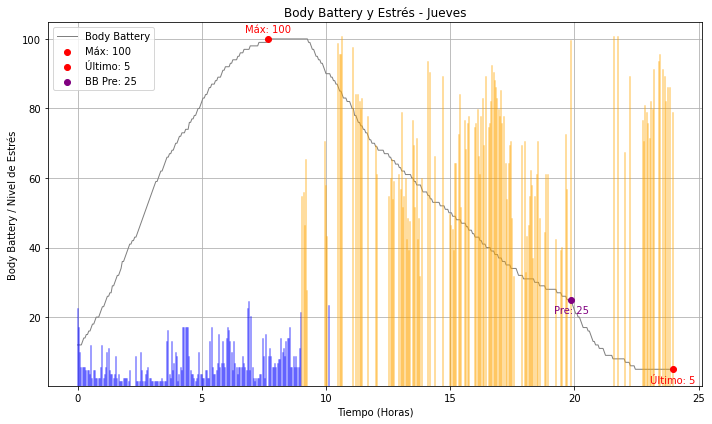

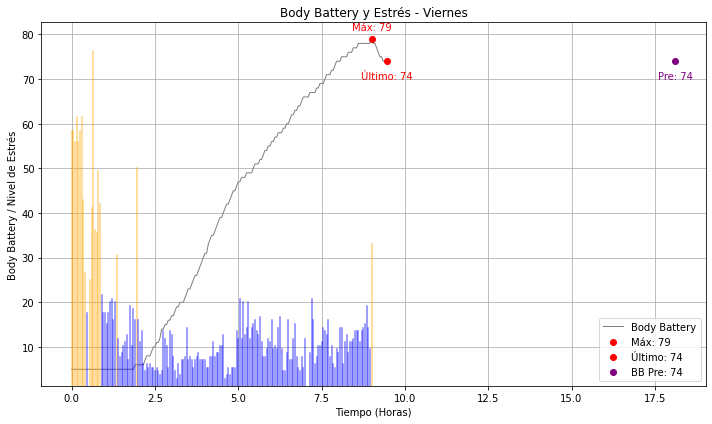

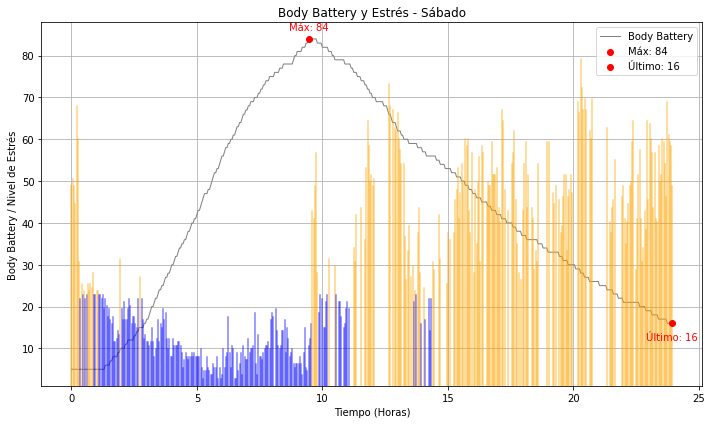

Datos de estrés pre y post entrenamiento:
         Día  Estrés Pre-Entrenamiento  Estrés Post-Entrenamiento  \
0      Lunes                 63.606299                        NaN   
1     Martes                 60.620968                        NaN   
2  Miércoles                       NaN                        NaN   
3     Jueves                 51.678571                  80.142857   
4    Viernes                 39.000000                        NaN   
5     Sábado                       NaN                        NaN   

   Estrés Medio Día Descanso  
0                        NaN  
1                        NaN  
2                  51.811688  
3                        NaN  
4                        NaN  
5                  49.711443  

Datos de Body Battery (Máximo y Final):
         Día  Body Battery Máx  Hora Máx  Body Battery Final  Hora Final  \
0      Lunes                97      8.00                  23       19.60   
1     Martes                80      7.45                  24    

In [9]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

# Carpeta principal
carpeta_estres = 'C:/Users/marco/Downloads/datosTFG/usuario1/Estres'

# Función para extraer el número del archivo
def obtener_numero(archivo):
    return int(re.search(r'(\d+)\.json$', archivo).group(1))

# Ordenar los archivos por el índice al final
archivos_json = sorted([archivo for archivo in os.listdir(carpeta_estres) if archivo.endswith('.json')], key=obtener_numero)

# Función para convertir el formato de "hora:minuto" a segundos
def convertir_a_segundos(hora_str):
    horas, minutos = map(int, hora_str.split(":"))
    return horas * 3600 + minutos * 60

#Diccionarios y listas para almacenar variables
entrenamientos = { #Hora inicio y duración de los entrenamientos
    "Lunes": ("19:45", "01:36"),   
    "Martes": ("19:03", "01:36"),   
    "Jueves": ("19:52", "01:28"),   
    "Viernes": ("18:07", "01:31"),   
}
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
estres_dias = []
body_battery_dias = []

# Bucle principal
for idx, archivo in enumerate(archivos_json):
    dia_semana = dias_semana[idx % len(dias_semana)] #Recorremos dias de la semana con idx
    
    ruta_archivo = os.path.join(carpeta_estres, archivo)

    try:
        with open(ruta_archivo, 'r') as f:
            data = json.load(f)
    except ValueError as e:
        print(f"Error al leer {archivo}: {e}")
        continue

    # Inicializamos valores como None, ya que los datos están corruptos, para añadirlos al DF
    estres_pre = None
    estres_post = None
    estres_medio_descanso = None
    max_battery_value = None
    max_battery_time = None
    last_battery_value = None
    last_battery_time = None
    battery_pre_entrenamiento = None

    if isinstance(data, list) and len(data) > 0:
        estres_data = data[0]
        time_offset_body_battery = estres_data.get('timeOffsetBodyBatteryValues', {})
        time_offset_stress = estres_data.get('timeOffsetStressLevelValues', {})

        #DF con mapeos estrés/BB-timeOffset
        df_body_battery = pd.DataFrame(list(time_offset_body_battery.items()), columns=['TimeOffset', 'BodyBattery'])
        df_body_battery['TimeOffset'] = df_body_battery['TimeOffset'].astype(int) / 3600  # Pasamos a horas
        
        df_stress = pd.DataFrame(list(time_offset_stress.items()), columns=['TimeOffset', 'StressLevel'])
        df_stress['TimeOffset'] = df_stress['TimeOffset'].astype(int) / 3600 
        df_stress = df_stress[df_stress['StressLevel'] >= 0]  # Filtramos valores nulos

        #Valores máximos y finales de BB
        max_battery_time = df_body_battery.loc[df_body_battery['BodyBattery'].idxmax()]['TimeOffset']
        max_battery_value = df_body_battery['BodyBattery'].max()
        last_battery_value = df_body_battery['BodyBattery'].iloc[-1]
        last_battery_time = df_body_battery['TimeOffset'].iloc[-1]
        
        #Almacenamos la BB en listas
        body_battery_dias.append({
            'Día': dia_semana,
            'Body Battery Máx': max_battery_value,
            'Hora Máx': max_battery_time,
            'Body Battery Final': last_battery_value,
            'Hora Final': last_battery_time,
            'Body Battery Pre-Entrenamiento': battery_pre_entrenamiento
        })
        
         ## Hacemos separación pre y post entrenamiento para el estrés ##

        #Detectar si es un día de entrenamiento y calcular inicio y fin
        if dia_semana in entrenamientos:
            hora_inicio, duracion = entrenamientos[dia_semana]
            inicio_entrenamiento = convertir_a_segundos(hora_inicio) / 3600
            fin_entrenamiento = inicio_entrenamiento + convertir_a_segundos(duracion) / 3600
            
            #BB pre entrenamiento
            df_pre_entrenamiento_battery = df_body_battery[df_body_battery['TimeOffset'] < inicio_entrenamiento]
            if not df_pre_entrenamiento_battery.empty:
                battery_pre_entrenamiento = df_pre_entrenamiento_battery['BodyBattery'].iloc[-1]  

            #Estrés pre y post entrenamiento
            df_pre_entrenamiento = df_stress[(df_stress['TimeOffset'] >= max_battery_time) & 
                                             (df_stress['TimeOffset'] < inicio_entrenamiento) & 
                                             (df_stress['StressLevel'] >= 0)]
            df_post_entrenamiento = df_stress[(df_stress['TimeOffset'] > fin_entrenamiento) & 
                                              (df_stress['StressLevel'] >= 0)]

            estres_pre = df_pre_entrenamiento['StressLevel'].mean() if not df_pre_entrenamiento.empty else None
            estres_post = df_post_entrenamiento['StressLevel'].mean() if not df_post_entrenamiento.empty else None
            
            estres_dias.append({
                'Día': dia_semana, 
                'Estrés Pre-Entrenamiento': estres_pre,
                'Estrés Post-Entrenamiento': estres_post
            })
            
            #Añadimos BB pre a la lista
            body_battery_dias[-1]['Body Battery Pre-Entrenamiento'] = battery_pre_entrenamiento
        else:
            #Días de descanso
            df_dia_descanso = df_stress[df_stress['TimeOffset'] >= max_battery_time]
            estres_medio_descanso = df_dia_descanso['StressLevel'].mean() if not df_dia_descanso.empty else None

            estres_dias.append({
                'Día': dia_semana,
                'Estrés Medio Día Descanso': estres_medio_descanso
            })

        #Gráfica de evolución diaria de estrés y BB
        plt.figure(figsize=(10, 6))
        
        #BB continuo máx y último
        plt.plot(df_body_battery['TimeOffset'], df_body_battery['BodyBattery'], color='gray', linewidth=1, label='Body Battery')
        plt.scatter(max_battery_time, max_battery_value, color='red', zorder=5, label=f'Máx: {max_battery_value}')
        plt.scatter(last_battery_time, last_battery_value, color='red', zorder=5, label=f'Último: {last_battery_value}')
        if battery_pre_entrenamiento is not None:
            plt.scatter(inicio_entrenamiento, battery_pre_entrenamiento, color='purple', zorder=5, label=f'BB Pre: {battery_pre_entrenamiento}')
            plt.text(inicio_entrenamiento, battery_pre_entrenamiento - 4, f'Pre: {battery_pre_entrenamiento}', color='purple', fontsize=10, ha='center')
        plt.text(max_battery_time, max_battery_value + 2, f'Máx: {max_battery_value}', color='red', fontsize=10, ha='center')
        plt.text(last_battery_time, last_battery_value - 4, f'Último: {last_battery_value}', color='red', fontsize=10, ha='center')
        
        
        #Estrés con barras verticales
        for _, row in df_stress.iterrows():
            color = 'orange' if row['StressLevel'] > 25 else 'blue'
            plt.axvline(x=row['TimeOffset'], ymin=0, ymax=row['StressLevel'] / 100, color=color, alpha=0.5)

        plt.title(f'Body Battery y Estrés - {dia_semana}')
        plt.xlabel('Tiempo (Horas)')
        plt.ylabel('Body Battery / Nivel de Estrés')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

# DFs de estrés y BB
df_estres = pd.DataFrame(estres_dias)
df_body_battery = pd.DataFrame(body_battery_dias)

print("Datos de estrés pre y post entrenamiento:")
print(df_estres)
print("\nDatos de Body Battery (Máximo y Final):")
print(df_body_battery)


# Implementación del Algoritmo de Calificación del Rendimiento y la Recuperación

A continuación, se describe la estructura del código utilizado para implementar el algoritmo de calificación de rendimiento deportivo y recuperación.

El objetivo es presentar una visualización intuitiva que permita al usuario relacionar su recuperación con el desempeño en el entrenamiento. Esta visualización muestra las calificaciones globales de ambos aspectos, desglosadas por cada parámetro. Además, cada día se presentan comentarios o insights mediante un sistema de desplegables que justifican la calificación e incluyen recomendaciones. El valor numérico se muestra solo en los comentarios, simplificando la interfaz para que el usuario final no necesite conocimientos avanzados en ciencias del deporte.

## Estructura del Código

### Funciones de evaluación

A continuación, se explica la estructura de las funciones de evaluación y calificación de los parámetros, tomando como ejemplo la función `evaluar_fc` para la calificación de los parámetros de frecuencia cardíaca durante el entrenamiento. Esta misma estructura se aplica al resto de funciones.

La estructura general de estas funciones incluye los siguientes elementos:

- **Preparación del DataFrame:** Se ensambla el DataFrame a evaluar mediante procesamiento previo. Para ello, se utilizan métodos específicos de Pandas:
    - `merge(DF1, DF2, on, how)`: Fusiona DataFrames basados en parámetros comunes. Por ejemplo, en el análisis de frecuencia cardíaca, se combinan los DataFrames de FC media y de picos y valles mediante la columna `Día` con el parámetro `how=outer`, que conserva todos los valores de la columna común aunque alguno esté vacío en uno de los DataFrames.
    - `loc[x, y]`: Manipula el valor de una posición específica del DataFrame.
    - `shift(i)`: Desplaza las filas de una columna `i` posiciones, útil para generar valores del "día anterior" como estrés postentrenamiento o el body battery final, simplificando así los cálculos diarios. Se recomienda usar una copia del DataFrame original (`copy()`) para evitar excepciones.

- **Parámetros de entrada:** Las funciones de evaluación reciben como parámetros los DataFrames con los datos a evaluar, un diccionario con insights y los valores de referencia de umbral.

- **Declaración de variables y extracción de datos:** Se declara una lista para almacenar los resultados y se extraen los valores de cada fila iterada mediante `iterrows()`.

- **Evaluación:** Se utiliza una estructura condicional para asignar una calificación (en cuatro niveles) basada en los umbrales de referencia. Se almacena el insight correspondiente a la calificación en el diccionario de entrada, junto al valor numérico y sus unidades.

- **Resultados:** En cada iteración, se añaden la calificación y el comentario a un diccionario que asocia estos valores al día correspondiente, y se almacenan en la lista `resultados[]`. La función devuelve un DataFrame final a partir de esta lista de resultados, nombrado como `resultados_<parámetro>`.
    
    

    ## Funciones de Calificación

Este apartado explica cómo funcionan las funciones de calificación para evaluar la recuperación y el rendimiento en el entrenamiento: `calificar_recuperacion` y `calificar_rendimiento`. Ambas funciones comparten una estructura similar, con algunas adaptaciones específicas.

### Estructura General

- **Parámetros de entrada:** Las funciones reciben como entradas los DataFrames resultantes de la evaluación de cada parámetro y los diccionarios con sus pesos para la evaluación. Se definen cuatro diccionarios de pesos: tres para la calificación de la recuperación según el tipo de día y uno para el rendimiento. Adicionalmente, una variable booleana, `valid_stress`, indica si los datos de estrés y body battery son válidos.

- **Declaración de variables y extracción de datos:** Se declara una lista `resultados` que almacenará los resultados y que luego se convertirá en un DataFrame. El bucle principal itera sobre los días de la semana y distingue entre los tipos de día para extraer los datos.

    - **Función de recuperación:** Según el tipo de día (descanso, entrenamiento tras descanso o entrenamiento tras entrenamiento), se seleccionan los parámetros y se incluyen sus calificaciones e insights. También se controla la inclusión de los datos de estrés y body battery si son válidos. Los pesos aplicables se seleccionan en función del tipo de día.

    - **Función de rendimiento:** La calificación de rendimiento se aplica solo en días de entrenamiento. Para los días de descanso, se declaran los resultados con valores nulos y se omite el resto del bloque. En los días de entrenamiento, se crea un diccionario `parametros` que extrae las calificaciones y los insights de los DataFrames de entrada, además de almacenar la calificación del VO₂ máximo del usuario, que luego se utiliza para ajustar los límites de calificación.

- **Sistema de calificación:** El cálculo de la puntuación es similar para ambas funciones. Inicialmente se declaran variables para la puntuación total, la suma de pesos, una lista de comentarios y un diccionario que desglosa la calificación global en sus partes individuales.

    Un bucle `for` recorre cada parámetro, asigna una puntuación de 1 a 4 a cada calificación, la multiplica por el peso correspondiente y acumula estas puntuaciones y pesos. Los insights se estructuran en el formato `"<Parámetro>: <calificación> - <comentario>"`, y se crea el diccionario de calificaciones individuales.

    La puntuación total se obtiene dividiendo la suma de puntos ponderados entre la suma de los pesos y, según los límites, se asigna el nivel de calificación. En la función `calificar_rendimiento`, estos límites se adaptan en función de la calificación del VO₂ máximo.

- **Resultados:** Con la calificación global establecida, se crea el diccionario `resultados_dia`, que contiene la calificación global, el desglose en calificaciones individuales y los insights para cada día. Los resultados diarios se añaden a la lista `resultados`, que finalmente se convierte en un DataFrame. En la función de recuperación, si los datos de estrés y body battery no son válidos, se eliminan las columnas correspondientes.

Finalmente, los resultados se almacenan en una variable llamando a la función.


In [10]:
import ipywidgets as widgets
from IPython.display import display


## Datos y Valores de Referencia ##

#Usuario 1
VO2_Max = 43
zona_FC_optima = (152.04, 173.37) 
FC_asalto = 171
FC_recuperacion = 161.5
HRV_Basal = (53, 85)
BB_domingo = 10
estres_valido = False
#Usuario 2
#VO2_Max = 46
#zona_FC_optima = (171.5, 197) 
#FC_asalto = 181.3
#FC_recuperacion = 171
#HRV_Basal = (61, 92)
#BB_domingo = 21


#Diccionarios de insights por calificación para cada parámetro
insights_dict_fc = {
    'Excelente': {
        'hr_medio': "FC media en la zona óptima, mantén el ritmo!",
        'Picos Medios': "FC en los asaltos óptima, no hay riesgo de sobreesfuerzo!",
        'Valles Medios': "FC en reposo óptima, recuperación óptima!"
    },
    'Buena': {
        'hr_medio': "FC media cerca de la zona óptima, genial pero aún puedes mejorar!",
        'Picos Medios': "FC en los asaltos controlada, rendimiento aceptable.",
        'Valles Medios': "FC en reposo controlada, recuperación favorable."
    },
    'Regular': {
        'hr_medio': "FC media fuera de la zona óptima, intenta bajar el ritmo.",
        'Picos Medios': "FC en los asaltos algo alta, hay que bajar el ritmo.",
        'Valles Medios': "FC en reposo algo alta, hay que bajar el ritmo."
    },
    'Mala': {
        'hr_medio': "La frecuencia media está fuera de la zona óptima, es necesario ajustar el ritmo.",
        'Picos Medios': "FC en los asaltos muy alta, hay riesgo de sobreesfuerzo.",
        'Valles Medios': "FC en reposo muy alta, recuperación entre asaltos no favorable."
    }
}

insights_dict_hrv = {
    'Excelente': {'HRV': "HRV óptimo, en niveles altos de tu rango basal"},
    'Buena': {'HRV': "HRV bueno, dentro de tu rango basal"},
    'Regular': {'HRV': "HRV desbalanceado, hoy entrena con calma."},
    'Mala': {'HRV': "HRV bajo, se recomienda descansar hoy."}
}

insights_dict_resp = {
    'Excelente': {'Balance Respiración': "El balance respiratorio es excelente, indica buena regulación."},
    'Buena': {'Balance Respiración': "El balance respiratorio es bueno, cerca del nivel óptimo."},
    'Regular': {'Balance Respiración': "El balance respiratorio está algo elevado, puede ser necesario relajarse más."},
    'Mala': {'Balance Respiración': "El balance respiratorio está muy alto, sugiere tensión o fatiga."}
}

insights_dict_estres = {
    'Excelente': {
        'Estrés Pre-Entrenamiento': "Estrés pre-entrenamiento bajo, preparación óptima.",
        'Estrés Post-Entrenamiento': "Estrés post-entrenamiento bajo, recuperación óptima.",
        'Estrés Medio Día Descanso': "El nivel de estrés tu día de descanso ha sido óptimo.",
        'Estrés Post Entrenamiento Día Anterior': "El estrés tras el entrenamiento del día anterior fue bajo, recuperación óptima."
    },
    'Bueno': {
        'Estrés Pre-Entrenamiento': "Estrés pre-entrenamiento moderado, preparación adecuada.",
        'Estrés Post-Entrenamiento': "Estrés post-entrenamiento moderado, recuperación aceptable.",
        'Estrés Medio Día Descanso': "El nivel de estrés tu día de descanso ha sido aceptable.",
        'Estrés Post Entrenamiento Día Anterior': "El estrés tras el entrenamiento del día anterior fue moderado, recuperación adecuada."
    },
    'Regular': {
        'Estrés Pre-Entrenamiento': "Estrés pre-entrenamiento elevado, preparación deficiente.",
        'Estrés Post-Entrenamiento': "Estrés post-entrenamiento elevado, recuperación insuficiente.",
        'Estrés Medio Día Descanso': "El nivel de estrés en día de descanso es algo alto, intenta relajarte.",
        'Estrés Post Entrenamiento Día Anterior': "El estrés tras el entrenamiento del día anterior fue alto, recuperación deficiente."
    },
    'Malo': {
        'Estrés Pre-Entrenamiento': "Estrés pre-entrenamiento muy alto, mala preparación.",
        'Estrés Post-Entrenamiento': "Estrés post-entrenamiento muy elevado, recuperación deficiente.",
        'Estrés Medio Día Descanso': "El nivel de estrés en día de descanso fue muy alto, se recomienda relajación.",
        'Estrés Post Entrenamiento Día Anterior': "El estrés tras el entrenamiento del día anterior ue muy alto, recuperación pobre."
    }
}

insights_dict_body_battery = {
    'Excelente': {
        'Body Battery Máx': "Tu batería corporal se ha recargado con éxito!",
        'Body Battery Final': "Has acabado el día con energía!",
        'Body Battery Pre-Entrenamiento': "Tienes energía para afrontar el entrenamiento!"
    },
    'Bueno': {
        'Body Battery Máx': "Nivel máximo de body battery bueno, recarga adecuada.",
        'Body Battery Final': "Body battery final en buen estado.",
        'Body Battery Pre-Entrenamiento': "Nivel de body battery al inicio del entrenamiento es adecuado."
    },
    'Regular': {
        'Body Battery Máx': "Nivel máximo de body battery regular, podría mejorar la recarga.",
        'Body Battery Final': "Body battery final regular, posible fatiga.",
        'Body Battery Pre-Entrenamiento': "Nivel de body battery al inicio del entrenamiento es regular, podría afectar el rendimiento."
    },
    'Malo': {
        'Body Battery Máx': "Nivel máximo de body battery bajo, indica falta de recarga.",
        'Body Battery Final': "Body battery final muy bajo, alto riesgo de fatiga.",
        'Body Battery Pre-Entrenamiento': "Nivel de body battery bajo al inicio del entrenamiento, rendimiento comprometido."
    }
}





#Funciones de evaluación y calificación de parámetros#

#VO2 Máximo
def evaluar_vo2(vo2):
    
    if vo2 > 54.5:
        calificacion = 'Excelente'
    elif vo2 > 45.4:
        calificacion = 'Buena'
    elif vo2 > 41.7:
        calificacion = 'Regular'
    else:
        calificacion = 'Mala'
    
    resultado = pd.DataFrame([{
        'VO2 Máximo': vo2,
        'Calificación VO2': calificacion
    }])
    return resultado

resultados_vo2 = evaluar_vo2(VO2_Max)
print(f" VO2 Máximo actual: {resultados_vo2['VO2 Máximo'].iloc[0]} ml/kg/min")


## FC ##
#DF con datos de FC
fc_df = pd.merge(hr_df, df_picos_valles, on='Día', how='outer')

#Función de evaluación y calificación de los parámetros de frecuencia cardíaca durante el entrenamiento
def evaluar_fc(df, insights_dict, zona_FC_optima, FC_asalto, FC_recuperacion):
    resultados = []
    
    for index, row in df.iterrows():
        #Extracción de los datos
        dia = row['Día']
        hr_medio = row['hr_medio']
        picos_medios = row['Picos Medios']
        valles_medios = row['Valles Medios']
        
        #Evaluación de la FC media con ZFCO
        if pd.notna(hr_medio):
            if zona_FC_optima[0] + 5 <= hr_medio <= zona_FC_optima[1] - 5:
                calificacion_hr = 'Excelente'
            elif zona_FC_optima[0] <= hr_medio <= zona_FC_optima[1]:
                calificacion_hr = 'Buena'
            elif (zona_FC_optima[0] - 5 <= hr_medio < zona_FC_optima[0]) or (zona_FC_optima[1] < hr_medio <= zona_FC_optima[1] + 5):
                calificacion_hr = 'Regular'
            else:
                calificacion_hr = 'Mala'
        else:
            calificacion_hr = 'Mala'
        comentario_hr = f"{insights_dict[calificacion_hr]['hr_medio']} (Valor: {hr_medio:.2f} bpm)"
        
        
        #Evaluación de la FC de asaltos de actividad
        FC_ref = max(FC_asalto, zona_FC_optima[1])  
        if pd.notna(picos_medios):
            diff_picos = FC_ref - picos_medios
            if diff_picos > 5:
                calificacion_picos = 'Excelente'
            elif -2 < diff_picos <= 5:
                calificacion_picos = 'Buena'
            elif -10 <= diff_picos <= -2:
                calificacion_picos = 'Regular'
            else:
                calificacion_picos = 'Mala'
        else:
            calificacion_picos = 'Mala'
        comentario_picos = f"{insights_dict[calificacion_picos]['Picos Medios']} (Valor: {picos_medios:.2f} bpm)"
        
        #Evalaución de la FC de asaltos de recuperación
        if pd.notna(valles_medios):
            diff_valles = FC_recuperacion - valles_medios
            if diff_valles > 5:
                calificacion_valles = 'Excelente'
            elif -2 < diff_valles <= 5:
                calificacion_valles = 'Buena'
            elif -10 <= diff_valles <= -2:
                calificacion_valles = 'Regular'
            else:
                calificacion_valles = 'Mala'
        else:
            calificacion_valles = 'Mala'
        comentario_valles = f"{insights_dict[calificacion_valles]['Valles Medios']} (Valor: {valles_medios:.2f} bpm)"
        
        #Creamos diccionario con calificaciones e insights
        resultado_dia = {
            'Día': dia,
            'Calificación hr_medio': calificacion_hr,
            'Insight hr_medio': comentario_hr,
            'Calificación Picos Medios': calificacion_picos,
            'Insight Picos Medios': comentario_picos,
            'Calificación Valles Medios': calificacion_valles,
            'Insight Valles Medios': comentario_valles
        }
        
        resultados.append(resultado_dia)
    
    #Devolvemos un DF con los 
    return pd.DataFrame(resultados)

#Llamamos a la función y almacenamos el DF
resultados_fc = evaluar_fc(fc_df, insights_dict_fc, zona_FC_optima, FC_asalto, FC_recuperacion)
#print(calificaciones_fc)


#Evaluación del HRV
df_hrv_reducido = rmssd_df[['Día', 'Por la mañana']]

def evaluar_hrv(df, insights_dict, HRV_Basal):
    resultados = []
    
    hrv_medio = sum(HRV_Basal) / 2 #Necesitamos el valor medio del rango basal para la calificación
    
    for index, row in df.iterrows():
        dia = row['Día']
        hrv_valor = row['Por la mañana']
        
        #Evaluación de HRV
        if pd.notna(hrv_valor):
            if HRV_Basal[0] <= hrv_valor <= HRV_Basal[1]:  
                if hrv_valor >= hrv_medio:
                    calificacion_hrv = 'Excelente'
                else:
                    calificacion_hrv = 'Buena'
            else:  
                diff_hrv = min(abs(hrv_valor - HRV_Basal[0]), abs(hrv_valor - HRV_Basal[1]))
                if diff_hrv <= 10:
                    calificacion_hrv = 'Regular'
                else:
                    calificacion_hrv = 'Mala'
        else:
            calificacion_hrv = 'Mala'
        
        comentario_hrv = f"{insights_dict[calificacion_hrv]['HRV']} (Valor: {hrv_valor} ms)"
        
        #Creamos diccionario con calificaciones e insights
        resultado_dia = {
            'Día': dia,
            'Calificación HRV': calificacion_hrv,
            'Insight HRV': comentario_hrv
        }
        
        resultados.append(resultado_dia)
    
    return pd.DataFrame(resultados)

# Llamada a la función y visualización de resultados
resultados_hrv = evaluar_hrv(df_hrv_reducido, insights_dict_hrv, HRV_Basal)



## Sueño ##


#Evaluación del sueño
def evaluar_sueno(df):
    #Diccionario para traducir las calificaciones
    traducciones = {
        'EXCELLENT': 'Excelente',
        'GOOD': 'Bueno',
        'FAIR': 'Regular',
        'POOR': 'Malo'
    }
    
    resultados = []
    
    for index, row in df.iterrows():
        dia = row['Día']
        calificacion_global = traducciones.get(row['Calificación Global'], row['Calificación Global'])
        
        #Generar insights según cada aspecto de la rúbrica de Garmin
        aspectos = ['Duración Total', 'Estrés', 'Inquietud', 'Despertar', 'REM', 'Sueño Ligero', 'Sueño Profundo']
        insights = {
            'Excelente': [],
            'Bueno': [],
            'Regular': [],
            'Malo': []
        }
        
        for aspecto in aspectos:
            calificacion = row[aspecto]
            calificacion_traducida = traducciones.get(calificacion, calificacion)
            
            if calificacion_traducida == 'Excelente':
                insights['Excelente'].append(aspecto)
            elif calificacion_traducida == 'Bueno':
                insights['Bueno'].append(aspecto)
            elif calificacion_traducida == 'Regular':
                insights['Regular'].append(aspecto)
            elif calificacion_traducida == 'Malo':
                insights['Malo'].append(aspecto)
        
        comentario = f"Aspectos del sueño el {dia}: "
        for calificacion, items in insights.items():
            if items:
                comentario += f"{calificacion}: {', '.join(items)}. "
        
        #Diccionario de resultados diarios
        resultado_dia = {
            'Día': dia,
            'Calificación Global': calificacion_global,
            'Insight Sueño': comentario.strip()
        }
        
        resultados.append(resultado_dia)
    #Devolvemos DF
    return pd.DataFrame(resultados)

#Llamamos a la función
resultados_sueno = evaluar_sueno(df_sueno)
pd.set_option('display.max_colwidth', None)
#print(resultados_sueno)


#Evaluación del balance de respiración pre/post entrenamiento
df_resp_reducido = df_respiracion[['Día', 'Balance Respiración']]

def evaluar_respiracion(df, insights_dict):
    resultados = []
    
    for index, row in df.iterrows():
        dia = row['Día']
        balance_resp = row['Balance Respiración']
        
        #Evaluación 
        if pd.notna(balance_resp):
            if balance_resp <= 0.5:
                calificacion_resp = 'Excelente'
            elif balance_resp <= 1:
                calificacion_resp = 'Buena'
            elif balance_resp <= 1.5:
                calificacion_resp = 'Regular'
            else:
                calificacion_resp = 'Mala'
        else:
            calificacion_resp = 'Mala'
        
        #Insight
        comentario_resp = f" {insights_dict[calificacion_resp]['Balance Respiración']} (Valor: {balance_resp:.2f} rpm)"
        
        #Diccionario de resultados diarios
        resultado_dia = {
            'Día': dia,
            'Calificación Balance Respiración': calificacion_resp,
            'Insight Balance Respiración': comentario_resp
        }
        resultados.append(resultado_dia)
    
    return pd.DataFrame(resultados)

# Llamada a la función y visualización de resultados
resultados_resp = evaluar_respiracion(df_resp_reducido, insights_dict_resp)
#print(resultados_resp)


#Evaluación del BB y el estrés

#Pre procesamiento de DFs de BB y estrés
df_body_battery_reducido = df_body_battery[['Día', 'Body Battery Máx', 'Body Battery Final', 'Body Battery Pre-Entrenamiento']]
df_body_battery_reducido = df_body_battery_reducido.copy()
df_body_battery_reducido['Body Battery Final Día Anterior'] = df_body_battery_reducido['Body Battery Final'].shift(1)
df_body_battery_reducido.loc[[2,5],'Body Battery Final Día Anterior'] = None

df_estres['Estrés Post Entrenamiento Día Anterior'] = df_estres['Estrés Post-Entrenamiento'].shift(1)
df_estres.loc[[2,5],'Estrés Post Entrenamiento Día Anterior'] = None
df_estres_bb = pd.merge(df_estres, df_body_battery_reducido, on='Día', how='outer')

def evaluar_estres_body_battery(df, insights_dict_estres, insights_dict_body_battery):
    resultados = []
    
    for index, row in df.iterrows():
        dia = row['Día']
        resultado_dia = {'Día': dia} #Declaramos el diccionario de manera inicial porque la estructura es distinta.
        
        #Evaluación del estrés. Todos los parámetros de estrés se evaluan con el mismo criterio.
        parametros_estres = [
            'Estrés Pre-Entrenamiento', 'Estrés Post-Entrenamiento', 
            'Estrés Medio Día Descanso', 'Estrés Post Entrenamiento Día Anterior'
        ]
        
        for param in parametros_estres:
            valor = row[param]
            if pd.notna(valor):
                if valor <= 25:
                    calificacion = 'Excelente'
                elif valor <= 50:
                    calificacion = 'Bueno'
                elif valor <= 75:
                    calificacion = 'Regular'
                else:
                    calificacion = 'Malo'
                
                #Creamos columnas de calificación e insights directamente.
                resultado_dia[f'Calificación {param}'] = calificacion
                resultado_dia[f'Insight {param}'] = f"{insights_dict_estres[calificacion][param]} (Valor: {valor})"
        
        #Evaluación de parámetros de body battery
        valor_max = row['Body Battery Máx']
        if pd.notna(valor_max):
            if valor_max < 25:
                calificacion = 'Malo'
            elif valor_max < 50:
                calificacion = 'Regular'
            elif valor_max < 85:
                calificacion = 'Bueno'
            else:
                calificacion = 'Excelente'
            
            resultado_dia['Calificación Body Battery Máx'] = calificacion
            resultado_dia['Insight Body Battery Máx'] = f"{insights_dict_body_battery[calificacion]['Body Battery Máx']} (Valor: {valor_max})"

        valor_final = row['Body Battery Final']
        if pd.notna(valor_final):
            if valor_final < 10:  
                calificacion = 'Malo'
            elif valor_final < 15:
                calificacion = 'Regular'
            elif valor_final < 25:
                calificacion = 'Bueno'
            else:
                calificacion = 'Excelente'
            
            resultado_dia['Calificación Body Battery Final'] = calificacion
            resultado_dia['Insight Body Battery Final'] = f"{insights_dict_body_battery[calificacion]['Body Battery Final']} (Valor: {valor_final})"

        valor_pre = row['Body Battery Pre-Entrenamiento']
        if pd.notna(valor_pre):
            if valor_pre < 20:  
                calificacion = 'Malo'
            elif valor_pre < 35:
                calificacion = 'Regular'
            elif valor_pre < 50:
                calificacion = 'Bueno'
            else:
                calificacion = 'Excelente'
            
            resultado_dia['Calificación Body Battery Pre-Entrenamiento'] = calificacion
            resultado_dia['Insight Body Battery Pre-Entrenamiento'] = f"{insights_dict_body_battery[calificacion]['Body Battery Pre-Entrenamiento']} (Valor: {valor_pre})"
        
        
        resultados.append(resultado_dia)
    
    return pd.DataFrame(resultados)

#Llamamos a la función
resultados_estres_bb = evaluar_estres_body_battery(df_estres_bb, insights_dict_estres, insights_dict_body_battery)

#Calificación de BB final día anterior desplazando BB final
resultados_estres_bb = resultados_estres_bb.copy()
resultados_estres_bb['Calificación Body Battery Final Día Anterior'] = resultados_estres_bb['Calificación Body Battery Final'].shift(1)
#print(resultados_estres_bb)



#Pesos para ponderación de parámetros de recuperación por tipo de día
pesos_descanso = { #días de descanso
    'Calidad del Sueño': 2,
    'HRV': 2,
    'Body Battery Inicial': 1,
    'Body Battery Final': 2,               
    'Estrés Día Descanso': 1             
}

pesos_entrenamiento_post_descanso = { #días de entrenamiento tras día de descanso
    'Calificación Recuperación Día Descanso Anterior': 2,
    'Calidad del Sueño': 2,
    'HRV': 2,
    'Body Battery Inicial': 1,
    'Body Battery Pre-Entrenamiento': 2,   
    'Estrés Pre-Entrenamiento': 1          
}

pesos_entrenamiento_post_entrenamiento = { #días de entrenamiento tras día de entrenamiento
    'Calidad del Sueño': 2,
    'HRV': 2,
    'Body Battery Inicial': 1,
    'Body Battery Final Día Anterior': 1,  
    'Body Battery Pre-Entrenamiento': 2,   
    'Estrés Pre-Entrenamiento': 1,        
    'Estrés Post Entrenamiento Día Anterior': 1  
}


#Función para evaluar la recuperación.
def calificar_recuperacion(resultados_sueno, resultados_hrv, resultados_estres_bb, pesos_descanso, pesos_entrenamiento_post_descanso, pesos_entrenamiento_post_entrenamiento, valid_stress):
    resultados = []
    
    if not valid_stress: #Indicamos al usuario si sus datos de estrés no son válidos
        print('Datos de Estrés y Body Battery no disponibles')
        
    for index in range(len(resultados_fc)):
        dia = resultados_fc.loc[index, 'Día']
        
        
        ## Distinción por tipo de día para extracción de datos ##
        
        if dia in ["Miércoles", "Sábado"]:
            #Días de descanso
            parametros = {
                'Calidad del Sueño': (resultados_sueno.loc[index, 'Calificación Global'], resultados_sueno.loc[index, 'Insight Sueño']),
                'HRV': (resultados_hrv.loc[index, 'Calificación HRV'], resultados_hrv.loc[index, 'Insight HRV']),
                'Body Battery Inicial': (resultados_estres_bb.loc[index, 'Calificación Body Battery Máx'], resultados_estres_bb.loc[index, 'Insight Body Battery Máx'])
            }
            
            if valid_stress: #Añadimos estres y BB solo si está disponible
                parametros['Body Battery Final'] = (resultados_estres_bb.loc[index, 'Calificación Body Battery Final'], resultados_estres_bb.loc[index, 'Insight Body Battery Final'])
                parametros['Estrés Día Descanso'] = (resultados_estres_bb.loc[index, 'Calificación Estrés Medio Día Descanso'], resultados_estres_bb.loc[index, 'Insight Estrés Medio Día Descanso'])
            
            pesos_parametros = pesos_descanso

        else:
            #Días de entrenamiento
            if index > 0 and resultados_sueno.loc[index - 1, 'Día'] in ["Miércoles", "Sábado"]: #Después de día de descanso
                parametros = {
                    'Calificación Recuperación Día Descanso Anterior': (resultados[index - 1]['Calificación Recuperación'], None),
                    'Calidad del Sueño': (resultados_sueno.loc[index, 'Calificación Global'], resultados_sueno.loc[index, 'Insight Sueño']),
                    'HRV': (resultados_hrv.loc[index, 'Calificación HRV'], resultados_hrv.loc[index, 'Insight HRV']),
                    'Body Battery Inicial': (resultados_estres_bb.loc[index, 'Calificación Body Battery Máx'], resultados_estres_bb.loc[index, 'Insight Body Battery Máx'])
                }
                if valid_stress: #Añadimos estres y BB solo si está disponible
                    parametros['Body Battery Pre-Entrenamiento'] = (resultados_estres_bb.loc[index, 'Calificación Body Battery Pre-Entrenamiento'], resultados_estres_bb.loc[index, 'Insight Body Battery Pre-Entrenamiento'])
                    parametros['Estrés Pre-Entrenamiento'] = (resultados_estres_bb.loc[index, 'Calificación Estrés Pre-Entrenamiento'], resultados_estres_bb.loc[index, 'Insight Estrés Pre-Entrenamiento'])
                
                pesos_parametros = pesos_entrenamiento_post_descanso
                
            else: #Después de día de entrenamiento
                parametros = {
                    'Calidad del Sueño': (resultados_sueno.loc[index, 'Calificación Global'], resultados_sueno.loc[index, 'Insight Sueño']),
                    'HRV': (resultados_hrv.loc[index, 'Calificación HRV'], resultados_hrv.loc[index, 'Insight HRV']),
                    'Body Battery Inicial': (resultados_estres_bb.loc[index, 'Calificación Body Battery Máx'], resultados_estres_bb.loc[index, 'Insight Body Battery Máx'])
                }
                if valid_stress: #Añadimos estres y BB solo si está disponible
                    parametros['Body Battery Final Día Anterior'] = (resultados_estres_bb.loc[index, 'Calificación Body Battery Final Día Anterior'], resultados_estres_bb.loc[index, 'Insight Body Battery Final'])
                    parametros['Body Battery Pre-Entrenamiento'] = (resultados_estres_bb.loc[index, 'Calificación Body Battery Pre-Entrenamiento'], resultados_estres_bb.loc[index, 'Insight Body Battery Pre-Entrenamiento'])
                    parametros['Estrés Post Entrenamiento Día Anterior'] = (resultados_estres_bb.loc[index, 'Calificación Estrés Post Entrenamiento Día Anterior'], resultados_estres_bb.loc[index, 'Insight Estrés Post Entrenamiento Día Anterior'])
                    parametros['Estrés Pre-Entrenamiento'] = (resultados_estres_bb.loc[index, 'Calificación Estrés Pre-Entrenamiento'], resultados_estres_bb.loc[index, 'Insight Estrés Pre-Entrenamiento'])
                
                pesos_parametros = pesos_entrenamiento_post_entrenamiento
        
        
        ## Sistema de Calificación ##
        
        #Cálculo de la puntuación
        puntuacion_total = 0
        total_pesos = 0
        insights = []
        calificaciones_individuales = {} #Inicializamos el diccionario para desglose de la calificación global

        for param, (calificacion, comentario) in parametros.items(): #Recorremos las calificaciones y los comentarios para puntuar
            if pd.notna(calificacion):
                if calificacion == 'Excelente':
                    puntos = 4
                elif calificacion in ['Bueno', 'Buena']:
                    puntos = 3
                elif calificacion == 'Regular':
                    puntos = 2
                else:
                    puntos = 1

                #Se pondera según el peso del parámetro
                peso = pesos_parametros.get(param, 1) #Si no hay, por defecto coge 1
                puntuacion_total += puntos * peso
                total_pesos += peso

                #Estructura final de los insights
                if comentario:
                    insights.append(f"{param}: {calificacion} - {comentario}")
                
                #Se añade la calificación a un diccionario para el desglose de la calificación global
                calificaciones_individuales[f'Calificación {param}'] = calificacion

        #Calificación según la puntuación
        
        puntuacion_promedio = puntuacion_total / total_pesos
        if puntuacion_promedio >= 3.5:
            calificacion_global = 'Excelente'
        elif puntuacion_promedio >= 2.5:
            calificacion_global = 'Buena'
        elif puntuacion_promedio >= 1.5:
            calificacion_global = 'Regular'
        else:
            calificacion_global = 'Mala'
        
        
        
        ## Resultados ##
        
        #Añadimos al diccionario
        resultado_dia = {
            'Día': dia,
            'Calificación Recuperación': calificacion_global,
            **calificaciones_individuales, #Añadimos el desglose en calificaciones individuales
            'Insight Recuperación': " \n".join(insights)
        }
        
        resultados.append(resultado_dia)
    
    #Convertir lista de resultados en DataFrame
    df_resultados = pd.DataFrame(resultados)

    #Nos aseguramos de que se filtran columnas de estrés y BB si el estrés no es válido
    if not valid_stress:
        df_resultados = df_resultados.loc[:, ~df_resultados.columns.str.contains('Estrés|Body Battery Pre|Body Battery Final')]

    return df_resultados


#Se almacena el DF con los resultados llamando a la función
resultados_recuperacion = calificar_recuperacion(
    resultados_sueno, resultados_hrv, resultados_estres_bb,
    pesos_descanso, pesos_entrenamiento_post_descanso, pesos_entrenamiento_post_entrenamiento,
    estres_valido
)




#Pesos para ponderación de parámetros de rendimiento
pesos_parametros_rend = {
    'Frecuencia Cardiaca Media': 3,
    'Picos Frecuencia Cardiaca': 1,
    'Valles Frecuencia Cardiaca': 1,
    'Balance Respiración': 2
}

#Función para evaluar el rendimiento del entrenamiento
def calificar_rendimiento(resultados_fc, resultados_resp, resultados_vo2, pesos_parametros):
    resultados = []
    
    for index in range(len(resultados_fc)):
        dia = resultados_fc.loc[index, 'Día']
        
        #Declaramos valores nulos para los días sin entrenamiento
        if dia in ["Miércoles", "Sábado"]:
            resultado_dia = {
                'Día': dia,
                'Calificación Rendimiento': None,
                'Insight Rendimiento': None,
                'Calificación VO2 Máximo': None,
                'Calificación Frecuencia Cardiaca Media': None,
                'Calificación Picos Frecuencia Cardiaca': None,
                'Calificación Valles Frecuencia Cardiaca': None,
                'Calificación Balance Respiración': None
            }
            resultados.append(resultado_dia)
            continue 
        
        #Extracción de datos
        parametros = {
            'Frecuencia Cardiaca Media': (resultados_fc.loc[index, 'Calificación hr_medio'], resultados_fc.loc[index, 'Insight hr_medio']),
            'Picos Frecuencia Cardiaca': (resultados_fc.loc[index, 'Calificación Picos Medios'], resultados_fc.loc[index, 'Insight Picos Medios']),
            'Valles Frecuencia Cardiaca': (resultados_fc.loc[index, 'Calificación Valles Medios'], resultados_fc.loc[index, 'Insight Valles Medios']),
            'Balance Respiración': (resultados_resp.loc[index, 'Calificación Balance Respiración'], resultados_resp.loc[index, 'Insight Balance Respiración'])
        }
        calificacion_vo2 = resultados_vo2.loc[0, 'Calificación VO2'] 
        
        
            
        ## Sistema de Calificación ##
        
        #Cálculo de la puntuación 
        
        puntuacion_total = 0
        total_pesos = 0
        insights = []
        calificaciones_individuales = {'Calificación VO2 Máximo': calificacion_vo2} #Inicializamos el diccionario con VO2 para desglose de la calificación global
        
        
        for param, (calificacion, comentario) in parametros.items():
            if pd.notna(calificacion):  
                if calificacion == 'Excelente':
                    puntos = 4
                elif calificacion == 'Bueno' or calificacion == 'Buena':
                    puntos = 3
                elif calificacion == 'Regular':
                    puntos = 2
                else:
                    puntos = 1

                #Se pondera según el peso del parámetro
                peso = pesos_parametros.get(param, 1)  
                puntuacion_total += puntos * peso
                total_pesos += peso

                #Estructura final de los insights
                insights.append(f"{param}: {calificacion} - {comentario}")

                #Se añade la calificación a un diccionario para el desglose de la calificación global
                calificaciones_individuales[f'Calificación {param}'] = calificacion
        
        
        #Ajuste de los límites de puntuación según el VO2 máximo
        if calificacion_vo2 == 'Excelente':
            limites = {'excelente': 3.5, 'bueno': 2.5, 'regular': 1.5}  #Más restrictivo
        elif calificacion_vo2 == 'Bueno':
            limites = {'excelente': 3.4, 'bueno': 2.4, 'regular': 1.4}  
        elif calificacion_vo2 == 'Regular':
            limites = {'excelente': 3.3, 'bueno': 2.3, 'regular': 1.3}  
        else:
            limites = {'excelente': 3.2, 'bueno': 12, 'regular': 1.2}  #Menos permisivo
        
        #Calificación según la puntuación
        
        puntuacion_promedio = puntuacion_total / total_pesos
        if puntuacion_promedio >= limites['excelente']:
            calificacion_global = 'Excelente'
        elif puntuacion_promedio >= limites['bueno']:
            calificacion_global = 'Buena'
        elif puntuacion_promedio >= limites['regular']:
            calificacion_global = 'Regular'
        else:
            calificacion_global = 'Mala'
        
        
        
        ## Resultados ##
        
        #Añadimos al diccionario
        resultado_dia = {
            'Día': dia,
            'Calificación Rendimiento': calificacion_global,
            **calificaciones_individuales,
            'Insight Rendimiento': " \n".join(insights)
        }
        resultados.append(resultado_dia)
    
    return pd.DataFrame(resultados)


#Se almacena el DF con los resultados llamando a la función
resultados_rendimiento = calificar_rendimiento(resultados_fc, resultados_resp, resultados_vo2, pesos_parametros_rend)


## Visualización de la calificación ##
## Confección de la tabla ##

#Función para asignar un color de celda a cada calificación
def color_cell(calificacion):
    if calificacion == 'Mala' or calificacion == 'Malo':
        return 'background-color: red'
    elif calificacion == 'Regular':
        return 'background-color: yellow'
    elif calificacion == 'Buena' or calificacion == 'Bueno':
        return 'background-color: lightgreen'
    elif calificacion == 'Excelente':
        return 'background-color: green'
    else:
        return ''

#Función para añadir líneas a las celdas que indiquemos
def estilo_divisor(val):
    return 'border-left: 2px solid black; border-right: 2px solid black;'

#Juntamos ambos DFs en uno
resultados_completos = pd.merge(resultados_recuperacion, resultados_rendimiento, on = 'Día', how='outer').fillna('-')

#Excluimos los insights de la gráfica
tabla_sin_insights = resultados_completos.drop(columns=['Insight Recuperación', 'Insight Rendimiento'])

#Aplicamos el estilo de color y los bordes a las celdas indicadas
styled_tabla_sin_insights = tabla_sin_insights.style.applymap(
    color_cell, subset=tabla_sin_insights.columns.difference(['Día'])
).applymap(
    estilo_divisor, subset=['Calificación Recuperación']  
).applymap(
    estilo_divisor, subset=['Calificación Rendimiento']  
)   

#Mostramos la tabla con el estilo aplicado
display(styled_tabla_sin_insights)

## Sistema de desplegables ##
for idx, row in resultados_completos.iterrows():
    dia = row['Día']
    print(f"Detalles del {dia}:")
    
    #Desplegable para "Insight Recuperación"
    if pd.notna(row['Insight Recuperación']):
        desplegable_recuperacion = widgets.Accordion(children=[widgets.Textarea(value=row['Insight Recuperación'], layout=widgets.Layout(width='500px', height='100px'), disabled=True)])
        desplegable_recuperacion.set_title(0, f'Insights Recuperación - {dia}')
        display(desplegable_recuperacion)
    
    #Desplegable para "Insight Rendimiento"
    if pd.notna(row['Insight Rendimiento']):
        desplegable_rendimiento = widgets.Accordion(children=[widgets.Textarea(value=row['Insight Rendimiento'], layout=widgets.Layout(width='500px', height='100px'), disabled=True)])
        desplegable_rendimiento.set_title(0, f'Insights Rendimiento - {dia}')
        display(desplegable_rendimiento)
    
    print("\n" + "-"*100 + "\n")

 VO2 Máximo actual: 43 ml/kg/min
Datos de Estrés y Body Battery no disponibles


,Día,Calificación Recuperación,Calificación Calidad del Sueño,Calificación HRV,Calificación Body Battery Inicial,Calificación Calificación Recuperación Día Descanso Anterior,Calificación Rendimiento,Calificación VO2 Máximo,Calificación Frecuencia Cardiaca Media,Calificación Picos Frecuencia Cardiaca,Calificación Valles Frecuencia Cardiaca,Calificación Balance Respiración
0,Lunes,Buena,Regular,Excelente,Excelente,-,Buena,Regular,Excelente,Regular,Excelente,Regular
1,Martes,Buena,Regular,Buena,Bueno,-,Buena,Regular,Excelente,Buena,Excelente,Regular
2,Miércoles,Buena,Regular,Buena,Bueno,-,-,-,-,-,-,-
3,Jueves,Excelente,Excelente,Excelente,Excelente,Buena,Excelente,Regular,Buena,Buena,Excelente,Excelente
4,Viernes,Buena,Regular,Buena,Bueno,-,Buena,Regular,Buena,Excelente,Excelente,Mala
5,Sábado,Regular,Malo,Buena,Bueno,-,-,-,-,-,-,-


Detalles del Lunes:


Accordion(children=(Textarea(value='Calidad del Sueño: Regular - Aspectos del sueño el Lunes: Excelente: Durac…

Accordion(children=(Textarea(value='Frecuencia Cardiaca Media: Excelente - FC media en la zona óptima, mantén …


----------------------------------------------------------------------------------------------------

Detalles del Martes:


Accordion(children=(Textarea(value='Calidad del Sueño: Regular - Aspectos del sueño el Martes: Excelente: Estr…

Accordion(children=(Textarea(value='Frecuencia Cardiaca Media: Excelente - FC media en la zona óptima, mantén …


----------------------------------------------------------------------------------------------------

Detalles del Miércoles:


Accordion(children=(Textarea(value='Calidad del Sueño: Regular - Aspectos del sueño el Miércoles: Excelente: E…

Accordion(children=(Textarea(value='-', disabled=True, layout=Layout(height='100px', width='500px')),), _title…


----------------------------------------------------------------------------------------------------

Detalles del Jueves:


Accordion(children=(Textarea(value='Calidad del Sueño: Excelente - Aspectos del sueño el Jueves: Excelente: Du…

Accordion(children=(Textarea(value='Frecuencia Cardiaca Media: Buena - FC media cerca de la zona óptima, genia…


----------------------------------------------------------------------------------------------------

Detalles del Viernes:


Accordion(children=(Textarea(value='Calidad del Sueño: Regular - Aspectos del sueño el Viernes: Excelente: Est…

Accordion(children=(Textarea(value='Frecuencia Cardiaca Media: Buena - FC media cerca de la zona óptima, genia…


----------------------------------------------------------------------------------------------------

Detalles del Sábado:


Accordion(children=(Textarea(value='Calidad del Sueño: Malo - Aspectos del sueño el Sábado: Excelente: Estrés.…

Accordion(children=(Textarea(value='-', disabled=True, layout=Layout(height='100px', width='500px')),), _title…


----------------------------------------------------------------------------------------------------

